In [1]:
import os
import shap
import pickle
import openai
import warnings
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import scipy.interpolate
import statsmodels.api as sm

from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
from xgboost import XGBRegressor
from plotly.colors import n_colors
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from statsmodels.nonparametric.smoothers_lowess import lowess as sm_lowess

In [2]:
# The significance level is the probability of rejecting the null hypothesis when it is true.
alpha = 0.01

warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", None, "display.max_columns",
              None, 'display.max_colwidth', None)

os.environ["TOKENIZERS_PARALLELISM"] = "true"

openai.api_key = os.getenv('OPENAI_API_KEY')

In [3]:
path_dataset = os.path.join(os.path.dirname(os.getcwd()), 'Dataset')

path_result = os.path.join(os.path.dirname(os.getcwd()), 'Result')
if not os.path.exists(path_result):
    os.makedirs(path_result)

path_general = os.path.join(path_result, 'General')
if not os.path.exists(path_general):
    os.makedirs(path_general)

path_challenge = os.path.join(path_result, 'Challenge')
if not os.path.exists(path_challenge):
    os.makedirs(path_challenge)

path_solution = os.path.join(path_result, 'Solution')
if not os.path.exists(path_solution):
    os.makedirs(path_solution)

path_challenge_git_qa = os.path.join(path_challenge, 'Git vs QA')
if not os.path.exists(path_challenge_git_qa):
    os.makedirs(path_challenge_git_qa)

path_challenge_open_closed = os.path.join(path_challenge, 'Open vs Closed')
if not os.path.exists(path_challenge_open_closed):
    os.makedirs(path_challenge_open_closed)

path_challenge_so_to = os.path.join(
    path_challenge, 'Stack Overflow vs Tool-specific')
if not os.path.exists(path_challenge_so_to):
    os.makedirs(path_challenge_so_to)

path_challenge_azureml_sagemaker = os.path.join(
    path_challenge, 'AzureML vs SageMaker')
if not os.path.exists(path_challenge_azureml_sagemaker):
    os.makedirs(path_challenge_azureml_sagemaker)

path_challenge_evolution = os.path.join(path_challenge, 'Evolution')
if not os.path.exists(path_challenge_evolution):
    os.makedirs(path_challenge_evolution)

In [37]:
prompt_topic = '''You will be given a list of keywords for each topic, I want you to provide a description of each topic in a two-word phrase but guarantee that each description is exclusive to the other. Also, for each description, you need to attach short comments on what these keywords are talking about in general.
###\n'''

with open(os.path.join(path_challenge, 'Topic terms.pickle'), 'rb') as handle:
    topic_terms = pickle.load(handle)

topic_term_list = []
for index, topic in enumerate(topic_terms):
    terms = ', '.join([term[0] for term in topic])
    topic_term = f'Topic {index}: {terms}'
    topic_term_list.append(topic_term)

completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": prompt_topic +
               '\n'.join(topic_term_list) + '\n###\n'}],
    temperature=0,
    max_tokens=1500,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
    timeout=100,
    stream=False)

topic_challenge = completion.choices[0].message.content
print(topic_challenge)

Topic 0: Environment Setup - Setting up software environments for development and execution
Topic 1: Pipeline Automation - Automating the execution of data processing pipelines
Topic 2: Docker - Containerization platform for building, shipping, and running applications
Topic 3: Hyperparameter Tuning - Optimizing model performance by tuning hyperparameters
Topic 4: Git Version Control - Tracking changes to code and collaborating with others
Topic 5: GPU Acceleration - Using graphics processing units to speed up machine learning tasks
Topic 6: Artifact Management - Managing and storing artifacts such as models, datasets, and code
Topic 7: Model Deployment - Deploying machine learning models for use in production environments
Topic 8: Data Labeling - Assigning labels to data for use in supervised learning tasks
Topic 9: Data Visualization - Creating visual representations of data for analysis and communication
Topic 10: Logging Metrics - Recording and tracking performance metrics during m

In [48]:
topic_mapping_challenge = {
    0: ('Package Management', 'Installing and configuring software packages and dependencies'),
    1: ('Pipeline Configuration', 'Automating the execution of data processing pipelines'),
    2: ('Docker Configuration', 'Containerization platform for building, shipping, and running applications'),
    3: ('Hyperparameter Tuning', 'Optimizing model performance by tuning hyperparameters'),
    4: ('Code Versioning', 'Managing and tracking changes in a repository using Git'),
    5: ('GPU Configuration', 'Using graphics processing units to speed up machine learning tasks'),
    6: ('Artifact Management', 'Uploading, downloading, and storing artifacts'),
    7: ('Endpoint Deployment', 'Deploying machine learning models for use in production environments'),
    8: ('Data Labeling', 'Assigning labels to data for use in supervised learning tasks'),
    9: ('Data Visualization', 'Creating visual representations of data for analysis and communication'),
    10: ('Metrics Logging', 'Recording and tracking performance metrics during model training and evaluation'),
    11: ('Account Management', 'Managing user accounts and access to resources'),
    12: ('Apache Spark Configuration', 'Installing and configuring Apache Spark distributed computing system for big data processing'),
    13: ('TensorFlow Configuration', 'Installing and configuring the TensorFlow machine learning framework'),
    14: ('Text Processing', 'Analyzing and manipulating text data'),
    15: ('Pandas Dataframe', 'Manipulating and analyzing tabular data using the Pandas library'),
    16: ('Model Exporting', 'Saving and exporting trained machine learning models'),
    17: ('Role-based Access Control', 'Controlling access to resources based on user roles and permissions'),
    18: ('Batch Processing', 'Processing large amounts of data in batches'),
    19: ('Model Registry', 'Registering, managing, and versioning models'),
    20: ('Database Connectivity', 'Connecting to and interacting with databases'),
    21: ('Resource Quota Control', 'Setting and managing limits on resource usage'),
    22: ('API Invocation', 'Calling APIs to perform tasks or retrieve data'),
    23: ('Forecasting', 'Using automated machine learning to generate forecasts'),
    24: ('Columnar Manipulation', 'Working with and manipulating columns in datasets'),
    25: ('Object Detection', 'Using machine learning to analyze and interpret visual data'),
    26: ('Web Service', 'Deploying machine learning models as web services'),
    27: ('Kubernetes Orchestration', 'Open-source container orchestration platform for managing containerized applications'),
    28: ('Tree-based Model', 'Building, training, and cutting tree-like structure to make predictions'),
    29: ('CSV Manipulation', 'Reading, writing, and manipulating CSV files'),
    30: ('TensorBoard Logging', 'Visualizing and tracking model training and evaluation using TensorBoard'),
    31: ('Feature Roadmap', 'Planning and implementing new features for a platform or product'),
    32: ('Dataset Versioning', 'Managing and versioning datasets'),
    33: ('CloudWatch Monitoring', 'Monitoring and logging AWS resources and applications'),
    34: ('Speech-to-Text', 'Converting audio speech to text'),
    35: ('YAML Configuration', 'Configuring and defining stages in a pipeline using YAML files'),
    36: ('Data Storage', 'Storing and accessing data in cloud-based storage solutions'),
    37: ('VPC Neworking', 'Connecting to AWS services privately through a VPC'),
    38: ('Model Evaluation', 'Evaluating and improving the accuracy of machine learning models'),
    39: ('Model Serving', 'Preparing and querying input data for machine learning models'),
    40: ('Bucket Access Control', 'Managing access to cloud-based storage buckets'),
    41: ('Run Management', 'Managing and monitoring the execution of jobs and tasks'),
    42: ('Model Inference', 'Using trained machine learning models to make predictions'),
    43: ('Jupyter Notebook', 'Creating and running interactive notebooks for data analysis and visualization'),
}

In [ ]:
prompt_topic = '''You will be given a list of keywords for each topic, I want you to provide a description of each topic in a two-word phrase but guarantee that each description is exclusive to the other. Also, for each description, you need to attach short comments on what these keywords are talking about in general.
###\n'''

with open(os.path.join(path_solution, 'Topic terms.pickle'), 'rb') as handle:
    topic_terms = pickle.load(handle)

topic_term_list = []
for index, topic in enumerate(topic_terms):
    terms = ', '.join([term[0] for term in topic])
    topic_term = f'Topic {index}: {terms}'
    topic_term_list.append(topic_term)

completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": prompt_topic +
               '\n'.join(topic_term_list) + '\n###\n'}],
    temperature=0,
    max_tokens=1500,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
    timeout=100,
    stream=False)

topic_solution = completion.choices[0].message.content
print(topic_solution)

Topic 0: Git Tracking - Managing and tracking changes in a repository using Git.
Topic 1: Access Control - Managing user roles and permissions for accessing resources.
Topic 2: Environment Setup - Installing and configuring software packages and dependencies.
Topic 3: Logging Metrics - Capturing and analyzing data related to system performance and behavior.
Topic 4: Dataset Management - Organizing and manipulating data for use in machine learning models.
Topic 5: Docker Deployment - Packaging and deploying applications in containers using Docker.
Topic 6: Parameter Configuration - Setting and adjusting parameters for software programs.
Topic 7: YAML Configuration - Configuring and defining stages in a pipeline using YAML files.
Topic 8: Endpoint Deployment - Deploying and managing endpoints for accessing APIs and web services.
Topic 9: Jupyter Notebooks - Creating and running interactive notebooks for data analysis and visualization.
Topic 10: Pandas Dataframes - Manipulating and analy

In [49]:
topic_mapping_solution = {
    0: ('Code Versioning', 'Managing and tracking changes in a repository using Git'),
    1: ('Role-based Access Control', 'Controlling access to resources based on user roles and permissions'),
    2: ('Package Management', 'Installing and configuring software packages and dependencies'),
    3: ('Metrics Logging', 'Recording and tracking performance metrics during model training and evaluation'),
    4: ('Columnar Manipulation', 'Working with and manipulating columns in datasets'),
    5: ('Docker Configuration', 'Containerization platform for building, shipping, and running applications'),
    6: ('Hyperparameter Tuning', 'Optimizing model performance by tuning hyperparameters'),
    7: ('YAML Configuration', 'Configuring and defining stages in a pipeline using YAML files'),
    8: ('Endpoint Serving', 'Creating, deploying, and managing endpoints for REST and web services'),
    9: ('Jupyter Notebook', 'Creating and running interactive notebooks for data analysis and visualization'),
    10: ('Pandas Dataframe', 'Manipulating and analyzing tabular data using the Pandas library'),
    11: ('TensorFlow Configuration', 'Installing and configuring the TensorFlow machine learning framework'),
    12: ('Artifact Management', 'Uploading, downloading, and storing artifacts'),
    13: ('Endpoint Deployment', 'Deploying machine learning models for use in production environments'),
    14: ('Tree-based Model', 'Building, training, and cutting tree-like structure to make predictions'),
    15: ('Pipeline Configuration (Model)', 'Building, inputting, and parameterizing pipelines for API and object use'),
    16: ('JSON Payload', 'Formatting, serializing, and loading data'),
    17: ('Remote Configuration', 'Adding, modifying, and running remote URLs and resources'),
    18: ('Apache Spark Configuration', 'Installing and configuring Apache Spark distributed computing system for big data processing'),
    19: ('Model Wrapper', 'Using PyFunc and PythonModel interfaces, importing models, and loading models'),
    20: ('Data Transfer', 'Transferring data between cloud-based storage solutions'),
    21: ('Cluster Configuration', 'Running and managing distributed computing jobs'),
    22: ('Pipeline Configuration (Data)', 'Creating and managing data pipelines'),
    23: ('CSV Manipulation', 'Reading, writing, and manipulating CSV files'),
    24: ('Model Registry', 'Registering, managing, and versioning models'),
    25: ('Memory Management', 'Managing memory and distributing training for large datasets'),
    26: ('Model Application', 'Using neural networks for machine learning'),
    27: ('SDK Management', 'Managing SDK versions'),
    28: ('Serverless Serving', 'Invoking endpoints and APIs using Lambda functions and API gateways'),
}

In [50]:
topic_ensemble = [
    'Account Management',
    'Apache Spark Configuration',
    'API Invocation',
    'Artifact Management',
    'Batch Processing',
    'Bucket Access Control',
    'CloudWatch Monitoring',
    'Cluster Configuration',
    'Code Versioning',
    'Columnar Manipulation',
    'CSV Manipulation',
    'Data Labeling',
    'Data Storage',
    'Data Transfer',
    'Data Visualization',
    'Database Connectivity',
    'Dataset Versioning',
    'Docker Configuration',
    'GPU Configuration',
    'Hyperparameter Tuning',
    'JSON Payload',
    'Jupyter Notebook',
    'Kubernetes Orchestration',
    'Memory Management',
    'Metrics Logging',
    'Model Evaluation',
    'Model Exporting',
    'Model Inference',
    'Model Registry',
    'Model Serving',
    'Endpoint Serving',
    'Endpoint Deployment',
    'Serverless Serving',
    'Pandas Dataframe',
    'Pipeline Configuration',
    'Pipeline Configuration (Data)',
    'Pipeline Configuration (Model)',
    'Package Management',
    'Remote Configuration',
    'Resource Quota Control',
    'Role-based Access Control',
    'Run Management',
    'SDK Management',
    'TensorBoard Logging',
    'TensorFlow Configuration',
    'VPC Networking',
    'Web Service',
    'YAML Configuration',
]

macro_topic_ensemble_inverse = [
    # Code versioning refers to the practice of tracking changes to software code over time.
    {'Code Management': ['Code Versioning']},
    # These words are all related to data management and analysis. They refer to various tasks and techniques used to organize, manipulate, store, transfer, and analyze data.
    {'Data Management': ['Artifact Management', 'Columnar Manipulation', 'CSV Manipulation', 'Data Labeling', 'Data Storage',
                         'Data Transfer', 'Data Visualization', 'Database Connectivity', 'Dataset Versioning', 'Pandas Dataframe', 'Batch Processing']},
    # All of these words are related to the deployment and management of machine learning models or web services.
    {'Deployment Management': ['Endpoint Serving', 'Endpoint Deployment', 'Model Serving', 'Model Inference',
                               'JSON Payload', 'Web Service', 'Serverless Serving', 'API Invocation']},
    # All of these words relate to the configuration and management of infrastructure aspects of computer systems and networks. Specifically, they involve setting up and optimizing different components such as processing power, memory, network connections, and software to ensure that they work together efficiently and effectively.
    {'Infrastructure Management': ['Apache Spark Configuration', 'Cluster Configuration', 'Docker Configuration', 'GPU Configuration', 'VPC Networking', 'Memory Management',
                                   'Remote Configuration', 'Resource Quota Control', 'TensorFlow Configuration', 'Jupyter Notebook', 'Package Management', 'SDK Management', 'YAML Configuration']},
    # These words are all related to the management and optimization of data pipelines in software development.
    {'Lifecycle Management': ['Pipeline Configuration',
                              'Pipeline Configuration (Data)', 'Pipeline Configuration (Model)', 'Run Management', 'Kubernetes Orchestration']},
    # All of these words are related to the development and management of machine learning models.
    {'Model Management': ['Hyperparameter Tuning',
                          'Model Evaluation', 'Model Exporting', 'Model Registry']},
    # All of these words are related to monitoring and logging data in various systems.
    {'Report Management': ['CloudWatch Monitoring',
                           'Metrics Logging', 'TensorBoard Logging', 'Metrics Logging']},
    # All of these words are related to controlling access to information or resources in a system.
    {'Security Management': ['Account Management',
                             'Bucket Access Control', 'Role-based Access Control']},
]

macro_topic_ensemble = {}
for dictionary in macro_topic_ensemble_inverse:
    for key, values in dictionary.items():
        for inner_value in values:
            macro_topic_ensemble[inner_value] = key

macro_topic_to_index = {}
for index, topics in enumerate(macro_topic_ensemble_inverse):
    for topic in topics:
        macro_topic_to_index[topic] = index + 1

colors = n_colors('rgb(5, 200, 200)', 'rgb(200, 10, 10)',
                  len(macro_topic_ensemble_inverse), colortype='rgb')

In [66]:
df = pd.read_json(os.path.join(path_general, 'original.json'))
# BigQuery Stack Overflow public dataset is updated until Nov 24, 2022, 1:39:22 PM UTC-5
min(df['Challenge_creation_time']), max(df['Challenge_creation_time'])

(Timestamp('2014-08-08 14:04:22.160000'),
 Timestamp('2023-02-22 01:36:03.995000'))

In [68]:
# assign human-readable & high-level topics to challenges & solutions

df_topics = pd.read_json(os.path.join(path_general, 'original.json'))
# remove challenges that were created after the public dataset was released
df_topics = df_topics[df_topics['Challenge_creation_time'] < '2022-11-24']

for index, row in df_topics.iterrows():
    if row['Challenge_topic'] in topic_mapping_challenge and topic_mapping_challenge[row['Challenge_topic']][0] in topic_ensemble:
        topic = topic_mapping_challenge[row['Challenge_topic']][0]
        df_topics.at[index, 'Challenge_topic'] = topic
        df_topics.at[index,
                     'Challenge_topic_macro'] = macro_topic_ensemble[topic]
        if pd.isna(row['Challenge_comment_count']):
            df_topics.at[index, 'Challenge_comment_count'] = 0
    else:
        df_topics.drop(index, inplace=True)
        continue

    if row['Solution_topic'] in topic_mapping_solution and topic_mapping_solution[row['Solution_topic']][0] in topic_ensemble:
        topic = topic_mapping_solution[row['Solution_topic']][0]
        df_topics.at[index, 'Solution_topic'] = topic
        df_topics.at[index,
                     'Solution_topic_macro'] = macro_topic_ensemble[topic]
    else:
        df_topics.at[index, 'Solution_topic'] = np.nan
        df_topics.at[index, 'Solution_topic_macro'] = np.nan

df_topics['Challenge_comment_count'] = df_topics['Challenge_comment_count'].fillna(
    0)
df_topics['Challenge_participation_count'] = df_topics['Challenge_answer_count'] + \
    df_topics['Challenge_comment_count']

df_topics.to_json(os.path.join(path_general, 'filtered.json'),
                  indent=4, orient='records')

In [59]:
# Create challenge topic participation distribution tree map

df_topics = pd.read_json(os.path.join(path_general, 'filtered.json'))
df_topics['Challenge_topic_macro'] = df_topics['Challenge_topic_macro'].map(
    macro_topic_to_index)
df_topics['Solved'] = df_topics['Challenge_closed_time'].notna().map(
    {True: 'Closed', False: 'Open'})
df_topics['Count'] = 1

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Solved', 'Platform', 'Tool'],
    values='Count',
    color='Challenge_topic_macro',
    width=2000,
    height=1000,
)
fig.write_image(os.path.join(
    path_challenge, 'Challenge_topic_distribution.png'))

In [69]:
# Create challenge topic participation distribution tree map

df_topics = pd.read_json(os.path.join(path_general, 'filtered.json'))
df_topics['Challenge_topic_macro'] = df_topics['Challenge_topic_macro'].map(
    macro_topic_to_index)
df_topics['Solved'] = df_topics['Challenge_closed_time'].notna().map(
    {True: 'Closed', False: 'Open'})
df_topics['Challenge_participation_count'] = df_topics['Challenge_participation_count'].map(
    lambda x: 1e-07 if x == 0 else x)

fig = px.treemap(
    df_topics,
    path=[px.Constant('All'), 'Solved', 'Platform', 'Tool'],
    values='Challenge_participation_count',
    color='Challenge_topic_macro',
    width=2000,
    height=1000,
)
fig.write_image(os.path.join(
    path_challenge, 'Challenge_topic_participation_distribution.png'))

In [45]:
df_topics = pd.read_json(os.path.join(path_general, 'filtered.json'))
df_topics = df_topics[df_topics['Solution_topic_macro'].notna()]

categories = ['Challenge_topic_macro', 'Solution_topic_macro']
df_topics = df_topics.groupby(categories).size().reset_index(name='value')

# we only visualize strong connection
df_topics = df_topics[df_topics['value'] > 50]

newDf = pd.DataFrame()
for i in range(len(categories)-1):
    tempDf = df_topics[[categories[i], categories[i+1], 'value']]
    tempDf.columns = ['source', 'target', 'value']
    newDf = pd.concat([newDf, tempDf])
newDf = newDf.groupby(['source', 'target']).agg({'value': 'sum'}).reset_index()

label = list(np.unique(df_topics[categories].values))
source = newDf['source'].apply(lambda x: label.index(x))
target = newDf['target'].apply(lambda x: label.index(x))
value = newDf['value']

link = dict(source=source, target=target, value=value)
node = dict()
data = go.Sankey(
    link=link,
    node=dict(
        label=label,
        thickness=100,
        pad=30,
    ))

fig = go.Figure(data)
fig.update_layout(
    height=2000,
    width=2000,
    font=dict(size=20),
)
fig.write_image(os.path.join(path_general,
                'Challenge solution sankey.png'))

In [ ]:
df = pd.read_json(os.path.join(path_general, 'filtered.json'))

df_topics = []

for name, group in df.groupby('Challenge_topic'):
    Challenge_count = group['Challenge_topic'].count()
    Challenge_solved_ratio = group['Challenge_closed_time'].notna(
    ).sum() / Challenge_count
    Challenge_mean_score = group['Challenge_score'].mean()
    Challenge_mean_favorite_count = group['Challenge_favorite_count'].mean()
    Challenge_mean_link_count = group['Challenge_link_count'].mean()
    Challenge_mean_information_entropy = group['Challenge_information_entropy'].mean(
    )
    Challenge_mean_readability = group['Challenge_readability'].mean()
    Challenge_mean_sentence_count = group['Challenge_sentence_count'].mean()
    Challenge_mean_word_count = group['Challenge_word_count'].mean()
    Challenge_mean_unique_word_count = group['Challenge_unique_word_count'].mean(
    )
    Challenge_mean_view_count = group['Challenge_view_count'].mean()
    Challenge_mean_answer_count = group['Challenge_answer_count'].mean()
    Challenge_mean_comment_count = group['Challenge_comment_count'].mean()
    Challenge_mean_participation_count = group['Challenge_participation_count'].mean(
    )

    Solution_mean_score = group['Solution_score'].mean()
    Solution_mean_link_count = group['Solution_link_count'].mean()
    Solution_mean_information_entropy = group['Solution_information_entropy'].mean(
    )
    Solution_mean_readability = group['Solution_readability'].mean()
    Solution_mean_sentence_count = group['Solution_sentence_count'].mean()
    Solution_mean_word_count = group['Solution_word_count'].mean()
    Solution_mean_unique_word_count = group['Solution_unique_word_count'].mean(
    )
    Solution_mean_comment_count = group['Solution_comment_count'].mean()

    Challenge_mean_solved_time = group['Challenge_solved_time'].mean()
    Challenge_median_solved_time = group['Challenge_solved_time'].median()
    Challenge_adjusted_mean_solved_time = group['Challenge_adjusted_solved_time'].mean(
    )
    Challenge_adjusted_meadian_solved_time = group['Challenge_adjusted_solved_time'].median(
    )

    topic_info = {
        'Challenge topic': name,
        'Challenge count': Challenge_count,
        'Challenge solved ratio': Challenge_solved_ratio,
        'Challenge mean score': Challenge_mean_score,
        'Challenge mean favorite count': Challenge_mean_favorite_count,
        'Challenge mean link count': Challenge_mean_link_count,
        'Challenge mean information entropy': Challenge_mean_information_entropy,
        'Challenge mean readability': Challenge_mean_readability,
        'Challenge mean sentence count': Challenge_mean_sentence_count,
        'Challenge mean word count': Challenge_mean_word_count,
        'Challenge mean unique word count': Challenge_mean_unique_word_count,
        'Challenge mean view count': Challenge_mean_view_count,
        'Challenge mean answer count': Challenge_mean_answer_count,
        'Challenge mean comment count': Challenge_mean_comment_count,
        'Challenge mean participation count': Challenge_mean_participation_count,

        'Solution mean score': Solution_mean_score,
        'Solution mean link count': Solution_mean_link_count,
        'Solution mean information entropy': Solution_mean_information_entropy,
        'Solution mean readability': Solution_mean_readability,
        'Solution mean sentence count': Solution_mean_sentence_count,
        'Solution mean word count': Solution_mean_word_count,
        'Solution mean unique word count': Solution_mean_unique_word_count,
        'Solution mean comment count': Solution_mean_comment_count,

        'Challenge mean solved time': Challenge_mean_solved_time,
        'Challenge median solved time': Challenge_median_solved_time,
        'Challenge adjusted mean solved time': Challenge_adjusted_mean_solved_time,
        'Challenge adjusted median solved time': Challenge_adjusted_meadian_solved_time,
    }
    df_topics.append(topic_info)

df_topics = pd.DataFrame(df_topics)
df_topics.to_json(os.path.join(path_challenge, 'general.json'),
                  indent=4, orient='records')

In [4]:
# log scale all numerical values for better visualization of long-tailed distributions

df = pd.read_json(os.path.join(path_general, 'filtered.json'))

df['Challenge_answer_count'] = np.log(df['Challenge_answer_count'] + 1)
df['Challenge_comment_count'] = np.log(df['Challenge_comment_count'] + 1)
df['Challenge_participation_count'] = np.log(
    df['Challenge_participation_count'] + 1)
df['Challenge_favorite_count'] = np.log(df['Challenge_favorite_count'] + 1)
df['Challenge_link_count'] = np.log(df['Challenge_link_count'] + 1)
df['Challenge_readability'] = np.log(df['Challenge_readability'] + 1)
df['Challenge_score'] = np.log(df['Challenge_score'] + 1)
df['Challenge_view_count'] = np.log(df['Challenge_view_count'] + 1)
df['Challenge_information_entropy'] = np.log(
    df['Challenge_information_entropy'] + 1)
df['Challenge_sentence_count'] = np.log(df['Challenge_sentence_count'] + 1)
df['Challenge_unique_word_count'] = np.log(
    df['Challenge_unique_word_count'] + 1)
df['Challenge_word_count'] = np.log(df['Challenge_word_count'] + 1)
df['Solution_comment_count'] = np.log(df['Solution_comment_count'] + 1)
df['Solution_comment_count'] = np.log(df['Solution_comment_count'] + 1)
df['Solution_link_count'] = np.log(df['Solution_link_count'] + 1)
df['Solution_readability'] = np.log(df['Solution_readability'] + 1)
df['Solution_score'] = np.log(df['Solution_score'] + 1)
df['Solution_sentence_count'] = np.log(df['Solution_sentence_count'] + 1)
df['Solution_unique_word_count'] = np.log(df['Solution_unique_word_count'] + 1)
df['Solution_word_count'] = np.log(df['Solution_word_count'] + 1)
df['Challenge_solved_time'] = np.log(df['Challenge_solved_time'] + 1)
df['Challenge_adjusted_solved_time'] = np.log(
    df['Challenge_adjusted_solved_time'] + 1)

del df['Challenge_converted_from_issue']

df.to_json(os.path.join(path_general, 'logscale.json'),
           indent=4, orient='records')

In [71]:
# perform the Shapiro-Wilk test for normality to check if various metrics are Gaussian distributed

df = pd.read_json(os.path.join(path_general, 'filtered.json'))

_, p = shapiro(df['Challenge_answer_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge answer count: {result}Gaussian')

_, p = shapiro(df['Challenge_comment_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge comment count: {result}Gaussian')

_, p = shapiro(df['Challenge_participation_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge participation count: {result}Gaussian')

_, p = shapiro(df['Challenge_favorite_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge favorite count: {result}Gaussian')

_, p = shapiro(df['Challenge_link_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge link count: {result}Gaussian')

_, p = shapiro(df['Challenge_readability'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge readability: {result}Gaussian')

_, p = shapiro(df['Challenge_score'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge score: {result}Gaussian')

_, p = shapiro(df['Challenge_view_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge view count: {result}Gaussian')

_, p = shapiro(df['Challenge_information_entropy'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge information entropy: {result}Gaussian')

_, p = shapiro(df['Challenge_sentence_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge sentence count: {result}Gaussian')

_, p = shapiro(df['Challenge_unique_word_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge unique word count: {result}Gaussian')

_, p = shapiro(df['Challenge_word_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge word count: {result}Gaussian')

_, p = shapiro(df['Solution_comment_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating solution comment count: {result}Gaussian')

_, p = shapiro(df['Solution_comment_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating solution information entropy: {result}Gaussian')

_, p = shapiro(df['Solution_link_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating solution link count: {result}Gaussian')

_, p = shapiro(df['Solution_readability'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating solution readability: {result}Gaussian')

_, p = shapiro(df['Solution_score'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating solution score: {result}Gaussian')

_, p = shapiro(df['Solution_sentence_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating solution sentence count: {result}Gaussian')

_, p = shapiro(df['Solution_unique_word_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating solution unique word count: {result}Gaussian')

_, p = shapiro(df['Solution_word_count'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating solution word count: {result}Gaussian')

_, p = shapiro(df['Challenge_solved_time'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge solved time: {result}Gaussian')

_, p = shapiro(df['Challenge_adjusted_solved_time'])
result = 'non-' if p < alpha else ''
print(f'p = {p:.2f}, indicating challenge adjusted solved time: {result}Gaussian')

p = 0.00, indicating challenge answer count: non-Gaussian
p = 0.00, indicating challenge comment count: non-Gaussian
p = 0.00, indicating challenge participation count: non-Gaussian
p = 1.00, indicating challenge favorite count: Gaussian
p = 0.00, indicating challenge link count: non-Gaussian
p = 0.00, indicating challenge readability: non-Gaussian
p = 1.00, indicating challenge score: Gaussian
p = 1.00, indicating challenge view count: Gaussian
p = 0.00, indicating challenge information entropy: non-Gaussian
p = 0.00, indicating challenge sentence count: non-Gaussian
p = 0.00, indicating challenge unique word count: non-Gaussian
p = 0.00, indicating challenge word count: non-Gaussian
p = 1.00, indicating solution comment count: Gaussian
p = 1.00, indicating solution information entropy: Gaussian
p = 1.00, indicating solution link count: Gaussian
p = 1.00, indicating solution readability: Gaussian
p = 1.00, indicating solution score: Gaussian
p = 1.00, indicating solution sentence coun

In [72]:
# conduct Kruskal–Wallis test to check if various metrics differ significantly across topics

df = pd.read_json(os.path.join(path_general, 'filtered.json'))
groups = df['Challenge_topic_macro'].unique()

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_answer_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the challenge answer count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_comment_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the challenge comment count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_participation_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the challenge participation count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_favorite_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the challenge favorite count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_link_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the challenge link count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_readability'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the challenge readability of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]['Challenge_score']
        for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the challenge score of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_information_entropy'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the challenge information entropy of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_sentence_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the challenge sentence count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_view_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the challenge view count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_unique_word_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the challenge unique word count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_word_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the challenge word count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_solved_time'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the challenge solved time of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Challenge_adjusted_solved_time'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the challenge adjusted solved time of one topic is significantly different from the others')

df = df[df['Solution_topic_macro'].notna()]
groups = df['Challenge_topic_macro'].unique()

data = [df[df['Challenge_topic_macro'] == group]
        ['Solution_comment_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the solution comment count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Solution_information_entropy'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the solution information entropy of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]['Solution_link_count']
        for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the solution link count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Solution_readability'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the solution readability of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]['Solution_score']
        for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the solution score of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Solution_sentence_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the solution sentence count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]
        ['Solution_unique_word_count'] for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the solution unique word count of one topic is significantly different from the others')

data = [df[df['Challenge_topic_macro'] == group]['Solution_word_count']
        for group in groups]
_, p = kruskal(*data)
if p < alpha:
    print('At least the solution word count of one topic is significantly different from the others')

At least the challenge answer count of one topic is significantly different from the others
At least the challenge comment count of one topic is significantly different from the others
At least the challenge participation count of one topic is significantly different from the others
At least the challenge link count of one topic is significantly different from the others
At least the challenge readability of one topic is significantly different from the others
At least the challenge information entropy of one topic is significantly different from the others
At least the challenge sentence count of one topic is significantly different from the others
At least the challenge unique word count of one topic is significantly different from the others
At least the challenge word count of one topic is significantly different from the others
At least the solution information entropy of one topic is significantly different from the others
At least the solution link count of one topic is signific

In [85]:
# Collect and compared Q&A forum and Git repo challenges across different topics

df = pd.read_json(os.path.join(path_general, 'logscale.json'))

df_qa = df[df['Platform'].isin(['Stack Overflow', 'Tool-specific'])]
df_git = df[df['Platform'].isin(['Github', 'Gitlab'])]

# Challenge topic count
fig_challenge_count = go.Figure()
fig_challenge_count.add_trace(
    go.Violin(
        x=np.full(len(df_qa), 'Challenge topic count (higher level)'),
        y=df_qa['Challenge_topic_macro'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        name='QA',
    ))
fig_challenge_count.add_trace(
    go.Violin(
        x=np.full(len(df_git), 'Challenge topic count (higher level)'),
        y=df_git['Challenge_topic_macro'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        name='Git',
    ))
fig_challenge_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_count.write_image(os.path.join(
    path_challenge_git_qa, 'Challenge count.png'))

# Challenge score
fig_challenge_score = go.Figure()
fig_challenge_score.add_trace(
    go.Violin(
        x=df_qa['Challenge_topic_macro'],
        y=df_qa['Challenge_score'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        name='QA',
    ))
fig_challenge_score.add_trace(
    go.Violin(
        x=df_git['Challenge_topic_macro'],
        y=df_git['Challenge_score'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        name='Git',
    ))
fig_challenge_score.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_score.write_image(os.path.join(
    path_challenge_git_qa, 'Challenge score.png'))

# Challenge favorite count
fig_challenge_favorite_count = go.Figure()
fig_challenge_favorite_count.add_trace(
    go.Violin(
        x=df_qa['Challenge_topic_macro'],
        y=df_qa['Challenge_favorite_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        name='QA',
    ))
fig_challenge_favorite_count.add_trace(
    go.Violin(
        x=df_git['Challenge_topic_macro'],
        y=df_git['Challenge_favorite_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        name='Git',
    ))
fig_challenge_favorite_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_favorite_count.write_image(os.path.join(
    path_challenge_git_qa, 'Challenge favorite count.png'))

# Challenge link count
fig_challenge_link_count = go.Figure()
fig_challenge_link_count.add_trace(
    go.Violin(
        x=df_qa['Challenge_topic_macro'],
        y=df_qa['Challenge_link_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        name='QA',
    ))
fig_challenge_link_count.add_trace(
    go.Violin(
        x=df_git['Challenge_topic_macro'],
        y=df_git['Challenge_link_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        name='Git',
    ))
fig_challenge_link_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_link_count.write_image(os.path.join(
    path_challenge_git_qa, 'Challenge link count.png'))

# Challenge readability
fig_challenge_readability = go.Figure()
fig_challenge_readability.add_trace(
    go.Violin(
        x=df_qa['Challenge_topic_macro'],
        y=df_qa['Challenge_readability'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        name='QA',
    ))
fig_challenge_readability.add_trace(
    go.Violin(
        x=df_git['Challenge_topic_macro'],
        y=df_git['Challenge_readability'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        name='Git',
    ))
fig_challenge_readability.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_readability.write_image(os.path.join(
    path_challenge_git_qa, 'Challenge readability.png'))

# Challenge view count
fig_challenge_view_count = go.Figure()
fig_challenge_view_count.add_trace(
    go.Violin(
        x=df_qa['Challenge_topic_macro'],
        y=df_qa['Challenge_view_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        name='QA',
    ))
fig_challenge_view_count.add_trace(
    go.Violin(
        x=df_git['Challenge_topic_macro'],
        y=df_git['Challenge_view_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        name='Git',
    ))
fig_challenge_view_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_view_count.write_image(os.path.join(
    path_challenge_git_qa, 'Challenge view count.png'))

# Challenge participation count
fig_challenge_participation_count = go.Figure()
fig_challenge_participation_count.add_trace(
    go.Violin(
        x=df_qa['Challenge_topic_macro'],
        y=df_qa['Challenge_participation_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        name='QA',
    ))
fig_challenge_participation_count.add_trace(
    go.Violin(
        x=df_git['Challenge_topic_macro'],
        y=df_git['Challenge_participation_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        name='Git',
    ))
fig_challenge_participation_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_participation_count.write_image(os.path.join(
    path_challenge_git_qa, 'Challenge participation count.png'))

# Challenge solved time
fig_challenge_solved_time = go.Figure()
fig_challenge_solved_time.add_trace(
    go.Violin(
        x=df_qa['Challenge_topic_macro'],
        y=df_qa['Challenge_solved_time'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        name='QA',
    ))
fig_challenge_solved_time.add_trace(
    go.Violin(
        x=df_git['Challenge_topic_macro'],
        y=df_git['Challenge_solved_time'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        name='Git',
    ))
fig_challenge_solved_time.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_solved_time.write_image(os.path.join(
    path_challenge_git_qa, 'Challenge solved time.png'))

# Challenge adjusted solved time
fig_challenge_adjusted_solved_time = go.Figure()
fig_challenge_adjusted_solved_time.add_trace(
    go.Violin(
        x=df_qa['Challenge_topic_macro'],
        y=df_qa['Challenge_adjusted_solved_time'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        name='QA',
    ))
fig_challenge_adjusted_solved_time.add_trace(
    go.Violin(
        x=df_git['Challenge_topic_macro'],
        y=df_git['Challenge_adjusted_solved_time'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        name='Git',
    ))
fig_challenge_adjusted_solved_time.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_adjusted_solved_time.write_image(os.path.join(
    path_challenge_git_qa, 'Challenge adjusted solved time.png'))

for name_group, color in zip(df.groupby('Challenge_topic_macro'), colors):
    name, group = name_group
    qa = group[group['Platform'].isin(['Stack Overflow', 'Tool-specific'])]
    git = group[group['Platform'].isin(['Github', 'Gitlab'])]

    # Challenge score
    challenge_score_qa = qa[qa['Challenge_score'].notna(
    )]['Challenge_score']
    challenge_score_git = git[git['Challenge_score'].notna(
    )]['Challenge_score']
    if len(challenge_score_qa) * len(challenge_score_git) > 0:
        _, p = mannwhitneyu(challenge_score_qa, challenge_score_git)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of Q&A fora vs Git repos challenge regarding higher level topic {name} in challenge score')

    # Challenge favorite count
    challenge_favorite_count_qa = qa[qa['Challenge_favorite_count'].notna(
    )]['Challenge_favorite_count']
    challenge_favorite_count_git = git[git['Challenge_favorite_count'].notna(
    )]['Challenge_favorite_count']
    if len(challenge_favorite_count_qa) * len(challenge_favorite_count_git) > 0:
        _, p = mannwhitneyu(challenge_favorite_count_qa,
                            challenge_favorite_count_git)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of Q&A fora vs Git repos challenge regarding higher level topic {name} in challenge favorite count')

    # Challenge link count
    challenge_link_count_qa = qa[qa['Challenge_link_count'].notna(
    )]['Challenge_link_count']
    challenge_link_count_git = git[git['Challenge_link_count'].notna(
    )]['Challenge_link_count']
    if len(challenge_link_count_qa) * len(challenge_link_count_git) > 0:
        _, p = mannwhitneyu(challenge_link_count_qa, challenge_link_count_git)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of Q&A fora vs Git repos challenge regarding higher level topic {name} in challenge link count')

    # Challenge readability
    challenge_readability_qa = qa[qa['Challenge_readability'].notna(
    )]['Challenge_readability']
    challenge_readability_git = git[git['Challenge_readability'].notna(
    )]['Challenge_readability']
    if len(challenge_readability_qa) * len(challenge_readability_git) > 0:
        _, p = mannwhitneyu(challenge_readability_qa,
                            challenge_readability_git)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of Q&A fora vs Git repos challenge regarding higher level topic {name} in challenge readability')

    # Challenge view count
    challenge_view_count_qa = qa[qa['Challenge_view_count'].notna(
    )]['Challenge_view_count']
    challenge_view_count_git = git[git['Challenge_view_count'].notna(
    )]['Challenge_view_count']
    if len(challenge_view_count_qa) * len(challenge_view_count_git) > 0:
        _, p = mannwhitneyu(challenge_view_count_qa,
                            challenge_view_count_git)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of Q&A fora vs Git repos challenge regarding higher level topic {name} in challenge answer count')

    # Challenge answer count
    challenge_answer_count_qa = qa['Challenge_answer_count']
    challenge_answer_count_git = git['Challenge_answer_count']
    if len(challenge_answer_count_qa) * len(challenge_answer_count_git) > 0:
        _, p = mannwhitneyu(challenge_answer_count_qa,
                            challenge_answer_count_git)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of Q&A fora vs Git repos challenge regarding higher level topic {name} in challenge answer count')

    # Challenge comment count
    challenge_comment_count_qa = qa['Challenge_comment_count']
    challenge_comment_count_git = git['Challenge_comment_count']
    if len(challenge_comment_count_qa) * len(challenge_comment_count_git) > 0:
        _, p = mannwhitneyu(challenge_comment_count_qa,
                            challenge_comment_count_git)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of Q&A fora vs Git repos challenge regarding higher level topic {name} in challenge comment count')

    # Challenge participation count
    challenge_participation_count_qa = qa['Challenge_participation_count']
    challenge_participation_count_git = git['Challenge_participation_count']
    if len(challenge_participation_count_qa) * len(challenge_participation_count_git) > 0:
        _, p = mannwhitneyu(challenge_participation_count_qa,
                            challenge_participation_count_git)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of Q&A fora vs Git repos challenge regarding higher level topic {name} in challenge participation count')

# Challenge mean solved time
challenge_mean_solved_time_qa = df_qa[['Challenge_topic_macro', 'Challenge_solved_time']].groupby(
    'Challenge_topic_macro').mean()['Challenge_solved_time']
challenge_mean_solved_time_git = df_git[['Challenge_topic_macro', 'Challenge_solved_time']].groupby(
    'Challenge_topic_macro').mean()['Challenge_solved_time']
_, p = mannwhitneyu(challenge_mean_solved_time_qa,
                    challenge_mean_solved_time_git)
if p < alpha:
    print(f'p = {p:.2f}, indicating different distribution of Q&A fora vs Git repos in higher level mean challenge solved time')

# Challenge median solved time
challenge_median_solved_time_qa = df_qa[['Challenge_topic_macro', 'Challenge_solved_time']].groupby(
    'Challenge_topic_macro').median()['Challenge_solved_time']
challenge_median_solved_time_git = df_git[['Challenge_topic_macro', 'Challenge_solved_time']].groupby(
    'Challenge_topic_macro').median()['Challenge_solved_time']
_, p = mannwhitneyu(challenge_median_solved_time_qa,
                    challenge_median_solved_time_git)
if p < alpha:
    print(f'p = {p:.2f}, indicating different distribution of Q&A fora vs Git repos in higher level median challenge solved time')

# Challenge adjusted mean solved time
challenge_adjusted_mean_solved_time_qa = df_qa[['Challenge_topic_macro', 'Challenge_adjusted_solved_time']].groupby(
    'Challenge_topic_macro').mean()['Challenge_adjusted_solved_time']
challenge_adjusted_mean_solved_time_git = df_git[['Challenge_topic_macro', 'Challenge_adjusted_solved_time']].groupby(
    'Challenge_topic_macro').mean()['Challenge_adjusted_solved_time']
_, p = mannwhitneyu(challenge_adjusted_mean_solved_time_qa,
                    challenge_adjusted_mean_solved_time_git)
if p < alpha:
    print(f'p = {p:.2f}, indicating different distribution of Q&A fora vs Git repos in higher level adjusted mean challenge solved time')

# Challenge adjusted median solved time
challenge_adjusted_median_solved_time_qa = df_qa[['Challenge_topic_macro', 'Challenge_adjusted_solved_time']].groupby(
    'Challenge_topic_macro').median()['Challenge_adjusted_solved_time']
challenge_adjusted_median_solved_time_git = df_git[['Challenge_topic_macro', 'Challenge_adjusted_solved_time']].groupby(
    'Challenge_topic_macro').median()['Challenge_adjusted_solved_time']
_, p = mannwhitneyu(challenge_adjusted_median_solved_time_qa,
                    challenge_adjusted_median_solved_time_git)
if p < alpha:
    print(f'p = {p:.2f}, indicating different distribution of Q&A fora vs Git repos in higher level adjusted median challenge solved time')

p = 0.00, indicating different distribution of Q&A fora vs Git repos challenge regarding higher level topic Code Management in challenge score
p = 0.00, indicating different distribution of Q&A fora vs Git repos challenge regarding higher level topic Code Management in challenge readability
p = 0.00, indicating different distribution of Q&A fora vs Git repos challenge regarding higher level topic Code Management in challenge answer count
p = 0.00, indicating different distribution of Q&A fora vs Git repos challenge regarding higher level topic Code Management in challenge participation count
p = 0.00, indicating different distribution of Q&A fora vs Git repos challenge regarding higher level topic Data Management in challenge score
p = 0.00, indicating different distribution of Q&A fora vs Git repos challenge regarding higher level topic Data Management in challenge readability
p = 0.00, indicating different distribution of Q&A fora vs Git repos challenge regarding higher level topic D

In [84]:
# Collect and compared open vs closed challenges across different topics

df = pd.read_json(os.path.join(path_general, 'logscale.json'))

df_open = df[df['Challenge_closed_time'].isna()]
df_closed = df[df['Challenge_closed_time'].notna()]

# Challenge topic count
fig_challenge_count = go.Figure()
fig_challenge_count.add_trace(
    go.Violin(
        x=np.full(len(df_open), 'Challenge topic count (higher level)'),
        y=df_open['Challenge_topic_macro'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        name='Open',
    ))
fig_challenge_count.add_trace(
    go.Violin(
        x=np.full(len(df_closed), 'Challenge topic count (higher level)'),
        y=df_closed['Challenge_topic_macro'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        name='Closed',
    ))
fig_challenge_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_count.write_image(os.path.join(
    path_challenge_open_closed, 'Challenge count.png'))

# Challenge score
fig_challenge_score = go.Figure()
fig_challenge_score.add_trace(
    go.Violin(
        x=df_open['Challenge_topic_macro'],
        y=df_open['Challenge_score'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='Open',
        scalegroup='Open',
        name='Open',
    ))
fig_challenge_score.add_trace(
    go.Violin(
        x=df_closed['Challenge_topic_macro'],
        y=df_closed['Challenge_score'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='Closed',
        scalegroup='Closed',
        name='Closed',
    ))
fig_challenge_score.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_score.write_image(os.path.join(
    path_challenge_open_closed, 'Challenge score.png'))

# Challenge favorite count
fig_challenge_favorite_count = go.Figure()
fig_challenge_favorite_count.add_trace(
    go.Violin(
        x=df_open['Challenge_topic_macro'],
        y=df_open['Challenge_favorite_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='Open',
        scalegroup='Open',
        name='Open',
    ))
fig_challenge_favorite_count.add_trace(
    go.Violin(
        x=df_closed['Challenge_topic_macro'],
        y=df_closed['Challenge_favorite_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='Closed',
        scalegroup='Closed',
        name='Closed',
    ))
fig_challenge_favorite_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_favorite_count.write_image(os.path.join(
    path_challenge_open_closed, 'Challenge favorite count.png'))

# Challenge link count
fig_challenge_link_count = go.Figure()
fig_challenge_link_count.add_trace(
    go.Violin(
        x=df_open['Challenge_topic_macro'],
        y=df_open['Challenge_link_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='Open',
        scalegroup='Open',
        name='Open',
    ))
fig_challenge_link_count.add_trace(
    go.Violin(
        x=df_closed['Challenge_topic_macro'],
        y=df_closed['Challenge_link_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='Closed',
        scalegroup='Closed',
        name='Closed',
    ))
fig_challenge_link_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_link_count.write_image(os.path.join(
    path_challenge_open_closed, 'Challenge link count.png'))

# Challenge readability
fig_challenge_readability = go.Figure()
fig_challenge_readability.add_trace(
    go.Violin(
        x=df_open['Challenge_topic_macro'],
        y=df_open['Challenge_readability'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='Open',
        scalegroup='Open',
        name='Open',
    ))
fig_challenge_readability.add_trace(
    go.Violin(
        x=df_closed['Challenge_topic_macro'],
        y=df_closed['Challenge_readability'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='Closed',
        scalegroup='Closed',
        name='Closed',
    ))
fig_challenge_readability.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_readability.write_image(os.path.join(
    path_challenge_open_closed, 'Challenge readability.png'))

# Challenge view count
fig_challenge_view_count = go.Figure()
fig_challenge_view_count.add_trace(
    go.Violin(
        x=df_open['Challenge_topic_macro'],
        y=df_open['Challenge_view_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='Open',
        scalegroup='Open',
        name='Open',
    ))
fig_challenge_view_count.add_trace(
    go.Violin(
        x=df_closed['Challenge_topic_macro'],
        y=df_closed['Challenge_view_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='Closed',
        scalegroup='Closed',
        name='Closed',
    ))
fig_challenge_view_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_view_count.write_image(os.path.join(
    path_challenge_open_closed, 'Challenge view count.png'))

# Challenge answer count
fig_challenge_answer_count = go.Figure()
fig_challenge_answer_count.add_trace(
    go.Violin(
        x=df_open['Challenge_topic_macro'],
        y=df_open['Challenge_answer_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='Open',
        scalegroup='Open',
        name='Open',
    ))
fig_challenge_answer_count.add_trace(
    go.Violin(
        x=df_closed['Challenge_topic_macro'],
        y=df_closed['Challenge_answer_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='Closed',
        scalegroup='Closed',
        name='Closed',
    ))
fig_challenge_answer_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_answer_count.write_image(os.path.join(
    path_challenge_open_closed, 'Challenge answer count.png'))

# Challenge comment count
fig_challenge_comment_count = go.Figure()
fig_challenge_comment_count.add_trace(
    go.Violin(
        x=df_open['Challenge_topic_macro'],
        y=df_open['Challenge_comment_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='Open',
        scalegroup='Open',
        name='Open',
    ))
fig_challenge_comment_count.add_trace(
    go.Violin(
        x=df_closed['Challenge_topic_macro'],
        y=df_closed['Challenge_comment_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='Closed',
        scalegroup='Closed',
        name='Closed',
    ))
fig_challenge_comment_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_comment_count.write_image(os.path.join(
    path_challenge_open_closed, 'Challenge comment count.png'))

# Challenge participation count
fig_challenge_participation_count = go.Figure()
fig_challenge_participation_count.add_trace(
    go.Violin(
        x=df_open['Challenge_topic_macro'],
        y=df_open['Challenge_participation_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='Open',
        scalegroup='Open',
        name='Open',
    ))
fig_challenge_participation_count.add_trace(
    go.Violin(
        x=df_closed['Challenge_topic_macro'],
        y=df_closed['Challenge_participation_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='Closed',
        scalegroup='Closed',
        name='Closed',
    ))
fig_challenge_participation_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_participation_count.write_image(os.path.join(
    path_challenge_open_closed, 'Challenge participation count.png'))

fig_challenge_solved_time_closed = go.Figure()
fig_challenge_adjusted_solved_time_closed = go.Figure()

for name_group, color in zip(df.groupby('Challenge_topic_macro'), colors):
    name, group = name_group
    open = group[group['Challenge_closed_time'].isna()]
    closed = group[group['Challenge_closed_time'].notna()]

    fig_challenge_solved_time_closed.add_trace(go.Violin(
        x=closed['Challenge_solved_time'], y=closed['Challenge_topic_macro'], line_color=color))
    fig_challenge_adjusted_solved_time_closed.add_trace(go.Violin(
        x=closed['Challenge_adjusted_solved_time'], y=closed['Challenge_topic_macro'], line_color=color))

    # Challenge score
    challenge_score_open = open[open['Challenge_score'].notna(
    )]['Challenge_score']
    challenge_score_closed = closed[closed['Challenge_score'].notna(
    )]['Challenge_score']
    if len(challenge_score_open) * len(challenge_score_closed) > 0:
        _, p = mannwhitneyu(challenge_score_open, challenge_score_closed)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of open vs closed challenge regarding higher level topic {name} in challenge score')

    # Challenge favorite count
    challenge_favorite_count_open = open[open['Challenge_favorite_count'].notna(
    )]['Challenge_favorite_count']
    challenge_favorite_count_closed = closed[closed['Challenge_favorite_count'].notna(
    )]['Challenge_favorite_count']
    if len(challenge_favorite_count_open) * len(challenge_favorite_count_closed) > 0:
        _, p = mannwhitneyu(challenge_favorite_count_open,
                            challenge_favorite_count_closed)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of open vs closed challenge regarding higher level topic {name} in challenge favorite count')

    # Challenge link count
    challenge_link_count_open = open[open['Challenge_link_count'].notna(
    )]['Challenge_link_count']
    challenge_link_count_closed = closed[closed['Challenge_link_count'].notna(
    )]['Challenge_link_count']
    if len(challenge_link_count_open) * len(challenge_link_count_closed) > 0:
        _, p = mannwhitneyu(challenge_link_count_open,
                            challenge_link_count_closed)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of open vs closed challenge regarding higher level topic {name} in challenge link count')

    # Challenge readability
    challenge_readability_open = open[open['Challenge_readability'].notna(
    )]['Challenge_readability']
    challenge_readability_closed = closed[closed['Challenge_readability'].notna(
    )]['Challenge_readability']
    if len(challenge_readability_open) * len(challenge_readability_closed) > 0:
        _, p = mannwhitneyu(challenge_readability_open,
                            challenge_readability_closed)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of open vs closed challenge regarding higher level topic {name} in challenge readability')

    # Challenge view count
    challenge_view_count_open = open[open['Challenge_view_count'].notna(
    )]['Challenge_view_count']
    challenge_view_count_closed = closed[closed['Challenge_view_count'].notna(
    )]['Challenge_view_count']
    if len(challenge_view_count_open) * len(challenge_view_count_closed) > 0:
        _, p = mannwhitneyu(challenge_view_count_open,
                            challenge_view_count_closed)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of open vs closed challenge regarding higher level topic {name} in challenge answer count')

    # Challenge answer count
    challenge_answer_count_open = open['Challenge_answer_count']
    challenge_answer_count_closed = closed['Challenge_answer_count']
    if len(challenge_answer_count_open) * len(challenge_answer_count_closed) > 0:
        _, p = mannwhitneyu(challenge_answer_count_open,
                            challenge_answer_count_closed)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of open vs closed challenge regarding higher level topic {name} in challenge answer count')

    # Challenge comment count
    challenge_comment_count_open = open['Challenge_comment_count']
    challenge_comment_count_closed = closed['Challenge_comment_count']
    if len(challenge_comment_count_open) * len(challenge_comment_count_closed) > 0:
        _, p = mannwhitneyu(challenge_comment_count_open,
                            challenge_comment_count_closed)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of open vs closed challenge regarding higher level topic {name} in challenge comment count')

    # Challenge participation count
    challenge_participation_count_open = open['Challenge_participation_count']
    challenge_participation_count_closed = closed['Challenge_participation_count']
    if len(challenge_participation_count_open) * len(challenge_participation_count_closed) > 0:
        _, p = mannwhitneyu(challenge_participation_count_open,
                            challenge_participation_count_closed)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of open vs closed challenge regarding higher level topic {name} in challenge participation count')

fig_challenge_solved_time_closed.update_traces(
    orientation='h', meanline_visible=True, side='positive', width=3, points=False)
fig_challenge_solved_time_closed.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
    xaxis_showgrid=False,
    xaxis_zeroline=False,
    showlegend=False,
    xaxis_title='Challenge solved time (hours) - Closed',
)
fig_challenge_solved_time_closed.write_image(os.path.join(
    path_challenge_open_closed, 'Challenge solved time (Closed).png'))

fig_challenge_adjusted_solved_time_closed.update_traces(
    orientation='h', meanline_visible=True, side='positive', width=3, points=False)
fig_challenge_adjusted_solved_time_closed.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
    xaxis_showgrid=False,
    xaxis_zeroline=False,
    showlegend=False,
    xaxis_title='Challenge adjusted solved time (hours) - Closed',
)
fig_challenge_adjusted_solved_time_closed.write_image(os.path.join(
    path_challenge_open_closed, 'Challenge adjusted solved time (Closed).png'))

p = 0.01, indicating different distribution of open vs closed challenge regarding higher level topic Code Management in challenge favorite count
p = 0.01, indicating different distribution of open vs closed challenge regarding higher level topic Code Management in challenge readability
p = 0.00, indicating different distribution of open vs closed challenge regarding higher level topic Code Management in challenge answer count
p = 0.00, indicating different distribution of open vs closed challenge regarding higher level topic Code Management in challenge participation count
p = 0.00, indicating different distribution of open vs closed challenge regarding higher level topic Data Management in challenge score
p = 0.00, indicating different distribution of open vs closed challenge regarding higher level topic Data Management in challenge favorite count
p = 0.00, indicating different distribution of open vs closed challenge regarding higher level topic Data Management in challenge answer co

In [83]:
# Collect and compared Stack Overflow vs tool-specific fora challenges across different topics

df = pd.read_json(os.path.join(path_general, 'logscale.json'))

df_so = df[df['Platform'] == 'Stack Overflow']
df_to = df[df['Platform'] == 'Tool-specific']

# Challenge topic count
fig_challenge_count = go.Figure()
fig_challenge_count.add_trace(
    go.Violin(
        x=np.full(len(df_so), 'Challenge topic count (higher level)'),
        y=df_so['Challenge_topic_macro'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        name='Stack Overflow',
    ))
fig_challenge_count.add_trace(
    go.Violin(
        x=np.full(len(df_to), 'Challenge topic count (higher level)'),
        y=df_to['Challenge_topic_macro'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        name='Tool-specific',
    ))
fig_challenge_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_count.write_image(os.path.join(
    path_challenge_so_to, 'Challenge count.png'))

# Challenge score
fig_challenge_score = go.Figure()
fig_challenge_score.add_trace(
    go.Violin(
        x=df_so['Challenge_topic_macro'],
        y=df_so['Challenge_score'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='Stack Overflow',
        scalegroup='Stack Overflow',
        name='Stack Overflow',
    ))
fig_challenge_score.add_trace(
    go.Violin(
        x=df_to['Challenge_topic_macro'],
        y=df_to['Challenge_score'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='Tool-specific',
        scalegroup='Tool-specific',
        name='Tool-specific',
    ))
fig_challenge_score.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_score.write_image(os.path.join(
    path_challenge_so_to, 'Challenge score.png'))

# Challenge favorite count
fig_challenge_favorite_count = go.Figure()
fig_challenge_favorite_count.add_trace(
    go.Violin(
        x=df_so['Challenge_topic_macro'],
        y=df_so['Challenge_favorite_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='Stack Overflow',
        scalegroup='Stack Overflow',
        name='Stack Overflow',
    ))
fig_challenge_favorite_count.add_trace(
    go.Violin(
        x=df_to['Challenge_topic_macro'],
        y=df_to['Challenge_favorite_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='Tool-specific',
        scalegroup='Tool-specific',
        name='Tool-specific',
    ))
fig_challenge_favorite_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_favorite_count.write_image(os.path.join(
    path_challenge_so_to, 'Challenge favorite count.png'))

# Challenge link count
fig_challenge_link_count = go.Figure()
fig_challenge_link_count.add_trace(
    go.Violin(
        x=df_so['Challenge_topic_macro'],
        y=df_so['Challenge_link_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='Stack Overflow',
        scalegroup='Stack Overflow',
        name='Stack Overflow',
    ))
fig_challenge_link_count.add_trace(
    go.Violin(
        x=df_to['Challenge_topic_macro'],
        y=df_to['Challenge_link_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='Tool-specific',
        scalegroup='Tool-specific',
        name='Tool-specific',
    ))
fig_challenge_link_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_link_count.write_image(os.path.join(
    path_challenge_so_to, 'Challenge link count.png'))

# Challenge readability
fig_challenge_readability = go.Figure()
fig_challenge_readability.add_trace(
    go.Violin(
        x=df_so['Challenge_topic_macro'],
        y=df_so['Challenge_readability'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='Stack Overflow',
        scalegroup='Stack Overflow',
        name='Stack Overflow',
    ))
fig_challenge_readability.add_trace(
    go.Violin(
        x=df_to['Challenge_topic_macro'],
        y=df_to['Challenge_readability'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='Tool-specific',
        scalegroup='Tool-specific',
        name='Tool-specific',
    ))
fig_challenge_readability.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_readability.write_image(os.path.join(
    path_challenge_so_to, 'Challenge readability.png'))

# Challenge view count
fig_challenge_view_count = go.Figure()
fig_challenge_view_count.add_trace(
    go.Violin(
        x=df_so['Challenge_topic_macro'],
        y=df_so['Challenge_view_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='Stack Overflow',
        scalegroup='Stack Overflow',
        name='Stack Overflow',
    ))
fig_challenge_view_count.add_trace(
    go.Violin(
        x=df_to['Challenge_topic_macro'],
        y=df_to['Challenge_view_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='Tool-specific',
        scalegroup='Tool-specific',
        name='Tool-specific',
    ))
fig_challenge_view_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_view_count.write_image(os.path.join(
    path_challenge_so_to, 'Challenge view count.png'))

# Challenge answer count
fig_challenge_answer_count = go.Figure()
fig_challenge_answer_count.add_trace(
    go.Violin(
        x=df_so['Challenge_topic_macro'],
        y=df_so['Challenge_answer_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='Stack Overflow',
        scalegroup='Stack Overflow',
        name='Stack Overflow',
    ))
fig_challenge_answer_count.add_trace(
    go.Violin(
        x=df_to['Challenge_topic_macro'],
        y=df_to['Challenge_answer_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='Tool-specific',
        scalegroup='Tool-specific',
        name='Tool-specific',
    ))
fig_challenge_answer_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_answer_count.write_image(os.path.join(
    path_challenge_so_to, 'Challenge answer count.png'))

# Challenge comment count
fig_challenge_comment_count = go.Figure()
fig_challenge_comment_count.add_trace(
    go.Violin(
        x=df_so['Challenge_topic_macro'],
        y=df_so['Challenge_comment_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='Stack Overflow',
        scalegroup='Stack Overflow',
        name='Stack Overflow',
    ))
fig_challenge_comment_count.add_trace(
    go.Violin(
        x=df_to['Challenge_topic_macro'],
        y=df_to['Challenge_comment_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='Tool-specific',
        scalegroup='Tool-specific',
        name='Tool-specific',
    ))
fig_challenge_comment_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_comment_count.write_image(os.path.join(
    path_challenge_so_to, 'Challenge comment count.png'))

# Challenge participation count
fig_challenge_participation_count = go.Figure()
fig_challenge_participation_count.add_trace(
    go.Violin(
        x=df_so['Challenge_topic_macro'],
        y=df_so['Challenge_participation_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='Stack Overflow',
        scalegroup='Stack Overflow',
        name='Stack Overflow',
    ))
fig_challenge_participation_count.add_trace(
    go.Violin(
        x=df_to['Challenge_topic_macro'],
        y=df_to['Challenge_participation_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='Tool-specific',
        scalegroup='Tool-specific',
        name='Tool-specific',
    ))
fig_challenge_participation_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_participation_count.write_image(os.path.join(
    path_challenge_so_to, 'Challenge participation count.png'))

# Challenge solved time
fig_challenge_solved_time = go.Figure()
fig_challenge_solved_time.add_trace(
    go.Violin(
        x=df_so['Challenge_topic_macro'],
        y=df_so['Challenge_solved_time'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='Stack Overflow',
        scalegroup='Stack Overflow',
        name='Stack Overflow',
    ))
fig_challenge_solved_time.add_trace(
    go.Violin(
        x=df_to['Challenge_topic_macro'],
        y=df_to['Challenge_solved_time'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='Tool-specific',
        scalegroup='Tool-specific',
        name='Tool-specific',
    ))
fig_challenge_solved_time.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_solved_time.write_image(os.path.join(
    path_challenge_so_to, 'Challenge solved time.png'))

# Challenge adjusted solved time
fig_challenge_adjusted_solved_time = go.Figure()
fig_challenge_adjusted_solved_time.add_trace(
    go.Violin(
        x=df_so['Challenge_topic_macro'],
        y=df_so['Challenge_adjusted_solved_time'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='Stack Overflow',
        scalegroup='Stack Overflow',
        name='Stack Overflow',
    ))
fig_challenge_adjusted_solved_time.add_trace(
    go.Violin(
        x=df_to['Challenge_topic_macro'],
        y=df_to['Challenge_adjusted_solved_time'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='Tool-specific',
        scalegroup='Tool-specific',
        name='Tool-specific',
    ))
fig_challenge_adjusted_solved_time.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_adjusted_solved_time.write_image(os.path.join(
    path_challenge_so_to, 'Challenge adjusted solved time.png'))

for name_group, color in zip(df.groupby('Challenge_topic_macro'), colors):
    name, group = name_group
    so = group[group['Platform'] == 'Stack Overflow']
    to = group[group['Platform'] == 'Tool-specific']

    # Challenge score
    challenge_score_so = so[so['Challenge_score'].notna(
    )]['Challenge_score']
    challenge_score_to = to[to['Challenge_score'].notna(
    )]['Challenge_score']
    if len(challenge_score_so) * len(challenge_score_to) > 0:
        _, p = mannwhitneyu(challenge_score_so, challenge_score_to)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of Stack Overflow vs tool-specific fora challenge regarding higher level topic {name} in challenge score')

    # Challenge favorite count
    challenge_favorite_count_so = so[so['Challenge_favorite_count'].notna(
    )]['Challenge_favorite_count']
    challenge_favorite_count_to = to[to['Challenge_favorite_count'].notna(
    )]['Challenge_favorite_count']
    if len(challenge_favorite_count_so) * len(challenge_favorite_count_to) > 0:
        _, p = mannwhitneyu(challenge_favorite_count_so,
                            challenge_favorite_count_to)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of Stack Overflow vs tool-specific fora challenge regarding higher level topic {name} in challenge favorite count')

    # Challenge link count
    challenge_link_count_so = so[so['Challenge_link_count'].notna(
    )]['Challenge_link_count']
    challenge_link_count_to = to[to['Challenge_link_count'].notna(
    )]['Challenge_link_count']
    if len(challenge_link_count_so) * len(challenge_link_count_to) > 0:
        _, p = mannwhitneyu(challenge_link_count_so, challenge_link_count_to)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of Stack Overflow vs tool-specific fora challenge regarding higher level topic {name} in challenge link count')

    # Challenge readability
    challenge_readability_so = so[so['Challenge_readability'].notna(
    )]['Challenge_readability']
    challenge_readability_to = to[to['Challenge_readability'].notna(
    )]['Challenge_readability']
    if len(challenge_readability_so) * len(challenge_readability_to) > 0:
        _, p = mannwhitneyu(challenge_readability_so,
                            challenge_readability_to)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of Stack Overflow vs tool-specific fora challenge regarding higher level topic {name} in challenge readability')

    # Challenge view count
    challenge_view_count_so = so[so['Challenge_view_count'].notna(
    )]['Challenge_view_count']
    challenge_view_count_to = to[to['Challenge_view_count'].notna(
    )]['Challenge_view_count']
    if len(challenge_view_count_so) * len(challenge_view_count_to) > 0:
        _, p = mannwhitneyu(challenge_view_count_so,
                            challenge_view_count_to)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of Stack Overflow vs tool-specific fora challenge regarding higher level topic {name} in challenge answer count')

    # Challenge answer count
    challenge_answer_count_so = so['Challenge_answer_count']
    challenge_answer_count_to = to['Challenge_answer_count']
    if len(challenge_answer_count_so) * len(challenge_answer_count_to) > 0:
        _, p = mannwhitneyu(challenge_answer_count_so,
                            challenge_answer_count_to)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of Stack Overflow vs tool-specific fora challenge regarding higher level topic {name} in challenge answer count')

    # Challenge comment count
    challenge_comment_count_so = so['Challenge_comment_count']
    challenge_comment_count_to = to['Challenge_comment_count']
    if len(challenge_comment_count_so) * len(challenge_comment_count_to) > 0:
        _, p = mannwhitneyu(challenge_comment_count_so,
                            challenge_comment_count_to)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of Stack Overflow vs tool-specific fora challenge regarding higher level topic {name} in challenge comment count')

    # Challenge participation count
    challenge_participation_count_so = so['Challenge_participation_count']
    challenge_participation_count_to = to['Challenge_participation_count']
    if len(challenge_comment_count_so) * len(challenge_comment_count_to) > 0:
        _, p = mannwhitneyu(challenge_comment_count_so,
                            challenge_comment_count_to)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of Stack Overflow vs tool-specific fora challenge regarding higher level topic {name} in challenge participation count')

# Challenge mean solved time
challenge_mean_solved_time_so = df_so[['Challenge_topic_macro', 'Challenge_solved_time']].groupby(
    'Challenge_topic_macro').mean()['Challenge_solved_time']
challenge_mean_solved_time_to = df_to[['Challenge_topic_macro', 'Challenge_solved_time']].groupby(
    'Challenge_topic_macro').mean()['Challenge_solved_time']
_, p = mannwhitneyu(challenge_mean_solved_time_so,
                    challenge_mean_solved_time_to)
if p < alpha:
    print(f'p = {p:.2f}, indicating different distribution of Stack Overflow vs tool-specific fora in higher level mean challenge solved time')

# Challenge median solved time
challenge_median_solved_time_so = df_so[['Challenge_topic_macro', 'Challenge_solved_time']].groupby(
    'Challenge_topic_macro').median()['Challenge_solved_time']
challenge_median_solved_time_to = df_to[['Challenge_topic_macro', 'Challenge_solved_time']].groupby(
    'Challenge_topic_macro').median()['Challenge_solved_time']
_, p = mannwhitneyu(challenge_median_solved_time_so,
                    challenge_median_solved_time_to)
if p < alpha:
    print(f'p = {p:.2f}, indicating different distribution of Stack Overflow vs tool-specific fora in higher level median challenge solved time')

# Challenge adjusted mean solved time
challenge_adjusted_mean_solved_time_so = df_so[['Challenge_topic_macro', 'Challenge_adjusted_solved_time']].groupby(
    'Challenge_topic_macro').mean()['Challenge_adjusted_solved_time']
challenge_adjusted_mean_solved_time_to = df_to[['Challenge_topic_macro', 'Challenge_adjusted_solved_time']].groupby(
    'Challenge_topic_macro').mean()['Challenge_adjusted_solved_time']
_, p = mannwhitneyu(challenge_adjusted_mean_solved_time_so,
                    challenge_adjusted_mean_solved_time_to)
if p < alpha:
    print(f'p = {p:.2f}, indicating different distribution of Stack Overflow vs tool-specific fora in higher level adjusted mean challenge solved time')

# Challenge adjusted median solved time
challenge_adjusted_median_solved_time_so = df_so[['Challenge_topic_macro', 'Challenge_adjusted_solved_time']].groupby(
    'Challenge_topic_macro').median()['Challenge_adjusted_solved_time']
challenge_adjusted_median_solved_time_to = df_to[['Challenge_topic_macro', 'Challenge_adjusted_solved_time']].groupby(
    'Challenge_topic_macro').median()['Challenge_adjusted_solved_time']
_, p = mannwhitneyu(challenge_adjusted_median_solved_time_so,
                    challenge_adjusted_median_solved_time_to)
if p < alpha:
    print(f'p = {p:.2f}, indicating different distribution of Stack Overflow vs tool-specific fora in higher level adjusted median challenge solved time')

p = 0.00, indicating different distribution of Stack Overflow vs tool-specific fora challenge regarding higher level topic Code Management in challenge score
p = 0.00, indicating different distribution of Stack Overflow vs tool-specific fora challenge regarding higher level topic Code Management in challenge favorite count
p = 0.00, indicating different distribution of Stack Overflow vs tool-specific fora challenge regarding higher level topic Code Management in challenge answer count
p = 0.00, indicating different distribution of Stack Overflow vs tool-specific fora challenge regarding higher level topic Code Management in challenge comment count
p = 0.00, indicating different distribution of Stack Overflow vs tool-specific fora challenge regarding higher level topic Code Management in challenge participation count
p = 0.00, indicating different distribution of Stack Overflow vs tool-specific fora challenge regarding higher level topic Data Management in challenge score
p = 0.00, indi

In [82]:
# Collect and compared SageMaker and AzureML challenges across different topics

df = pd.read_json(os.path.join(path_general, 'logscale.json'))

df_sagemaker = df[df['Tool'] == 'Amazon SageMaker']
df_azureml = df[df['Tool'] == 'Azure Machine Learning']

# Challenge topic count
fig_challenge_count = go.Figure()
fig_challenge_count.add_trace(
    go.Violin(
        x=np.full(len(df_sagemaker), 'Challenge topic count (higher level)'),
        y=df_sagemaker['Challenge_topic_macro'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        name='SageMaker',
    ))
fig_challenge_count.add_trace(
    go.Violin(
        x=np.full(len(df_azureml), 'Challenge topic count (higher level)'),
        y=df_azureml['Challenge_topic_macro'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        name='AzureML',
    ))
fig_challenge_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_count.write_image(os.path.join(
    path_challenge_azureml_sagemaker, 'Challenge count.png'))

# Challenge score
fig_challenge_score = go.Figure()
fig_challenge_score.add_trace(
    go.Violin(
        x=df_sagemaker['Challenge_topic_macro'],
        y=df_sagemaker['Challenge_score'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='SageMaker',
        scalegroup='SageMaker',
        name='SageMaker',
    ))
fig_challenge_score.add_trace(
    go.Violin(
        x=df_azureml['Challenge_topic_macro'],
        y=df_azureml['Challenge_score'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='AzureML',
        scalegroup='AzureML',
        name='AzureML',
    ))
fig_challenge_score.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_score.write_image(os.path.join(
    path_challenge_azureml_sagemaker, 'Challenge score.png'))

# Challenge favorite count
fig_challenge_favorite_count = go.Figure()
fig_challenge_favorite_count.add_trace(
    go.Violin(
        x=df_sagemaker['Challenge_topic_macro'],
        y=df_sagemaker['Challenge_favorite_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='SageMaker',
        scalegroup='SageMaker',
        name='SageMaker',
    ))
fig_challenge_favorite_count.add_trace(
    go.Violin(
        x=df_azureml['Challenge_topic_macro'],
        y=df_azureml['Challenge_favorite_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='AzureML',
        scalegroup='AzureML',
        name='AzureML',
    ))
fig_challenge_favorite_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_favorite_count.write_image(os.path.join(
    path_challenge_azureml_sagemaker, 'Challenge favorite count.png'))

# Challenge link count
fig_challenge_link_count = go.Figure()
fig_challenge_link_count.add_trace(
    go.Violin(
        x=df_sagemaker['Challenge_topic_macro'],
        y=df_sagemaker['Challenge_link_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='SageMaker',
        scalegroup='SageMaker',
        name='SageMaker',
    ))
fig_challenge_link_count.add_trace(
    go.Violin(
        x=df_azureml['Challenge_topic_macro'],
        y=df_azureml['Challenge_link_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='AzureML',
        scalegroup='AzureML',
        name='AzureML',
    ))
fig_challenge_link_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_link_count.write_image(os.path.join(
    path_challenge_azureml_sagemaker, 'Challenge link count.png'))

# Challenge readability
fig_challenge_readability = go.Figure()
fig_challenge_readability.add_trace(
    go.Violin(
        x=df_sagemaker['Challenge_topic_macro'],
        y=df_sagemaker['Challenge_readability'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='SageMaker',
        scalegroup='SageMaker',
        name='SageMaker',
    ))
fig_challenge_readability.add_trace(
    go.Violin(
        x=df_azureml['Challenge_topic_macro'],
        y=df_azureml['Challenge_readability'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='AzureML',
        scalegroup='AzureML',
        name='AzureML',
    ))
fig_challenge_readability.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_readability.write_image(os.path.join(
    path_challenge_azureml_sagemaker, 'Challenge readability.png'))

# Challenge view count
fig_challenge_view_count = go.Figure()
fig_challenge_view_count.add_trace(
    go.Violin(
        x=df_sagemaker['Challenge_topic_macro'],
        y=df_sagemaker['Challenge_view_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='SageMaker',
        scalegroup='SageMaker',
        name='SageMaker',
    ))
fig_challenge_view_count.add_trace(
    go.Violin(
        x=df_azureml['Challenge_topic_macro'],
        y=df_azureml['Challenge_view_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='AzureML',
        scalegroup='AzureML',
        name='AzureML',
    ))
fig_challenge_view_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_view_count.write_image(os.path.join(
    path_challenge_azureml_sagemaker, 'Challenge view count.png'))

# Challenge answer count
fig_challenge_answer_count = go.Figure()
fig_challenge_answer_count.add_trace(
    go.Violin(
        x=df_sagemaker['Challenge_topic_macro'],
        y=df_sagemaker['Challenge_answer_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='SageMaker',
        scalegroup='SageMaker',
        name='SageMaker',
    ))
fig_challenge_answer_count.add_trace(
    go.Violin(
        x=df_azureml['Challenge_topic_macro'],
        y=df_azureml['Challenge_answer_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='AzureML',
        scalegroup='AzureML',
        name='AzureML',
    ))
fig_challenge_answer_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_answer_count.write_image(os.path.join(
    path_challenge_azureml_sagemaker, 'Challenge answer count.png'))

# Challenge comment count
fig_challenge_comment_count = go.Figure()
fig_challenge_comment_count.add_trace(
    go.Violin(
        x=df_sagemaker['Challenge_topic_macro'],
        y=df_sagemaker['Challenge_comment_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='SageMaker',
        scalegroup='SageMaker',
        name='SageMaker',
    ))
fig_challenge_comment_count.add_trace(
    go.Violin(
        x=df_azureml['Challenge_topic_macro'],
        y=df_azureml['Challenge_comment_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='AzureML',
        scalegroup='AzureML',
        name='AzureML',
    ))
fig_challenge_comment_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_comment_count.write_image(os.path.join(
    path_challenge_azureml_sagemaker, 'Challenge comment count.png'))

# Challenge participation count
fig_challenge_participation_count = go.Figure()
fig_challenge_participation_count.add_trace(
    go.Violin(
        x=df_sagemaker['Challenge_topic_macro'],
        y=df_sagemaker['Challenge_participation_count'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='SageMaker',
        scalegroup='SageMaker',
        name='SageMaker',
    ))
fig_challenge_participation_count.add_trace(
    go.Violin(
        x=df_azureml['Challenge_topic_macro'],
        y=df_azureml['Challenge_participation_count'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='AzureML',
        scalegroup='AzureML',
        name='AzureML',
    ))
fig_challenge_participation_count.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_participation_count.write_image(os.path.join(
    path_challenge_azureml_sagemaker, 'Challenge participation count.png'))

# Challenge solved time
fig_challenge_solved_time = go.Figure()
fig_challenge_solved_time.add_trace(
    go.Violin(
        x=df_sagemaker['Challenge_topic_macro'],
        y=df_sagemaker['Challenge_solved_time'],
        meanline_visible=True,
        line_color='blue',
        side='positive',
        opacity=0.5,
        legendgroup='SageMaker',
        scalegroup='SageMaker',
        name='SageMaker',
    ))
fig_challenge_solved_time.add_trace(
    go.Violin(
        x=df_azureml['Challenge_topic_macro'],
        y=df_azureml['Challenge_solved_time'],
        meanline_visible=True,
        line_color='orange',
        side='negative',
        opacity=0.5,
        legendgroup='AzureML',
        scalegroup='AzureML',
        name='AzureML',
    ))
fig_challenge_solved_time.update_layout(
    height=1000,
    width=2000,
    font=dict(size=20),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig_challenge_solved_time.write_image(os.path.join(
    path_challenge_azureml_sagemaker, 'Challenge solved time.png'))

for name_group, color in zip(df.groupby('Challenge_topic_macro'), colors):
    name, group = name_group
    sagemaker = group[group['Tool'] == 'Amazon SageMaker']
    azureml = group[group['Tool'] == 'Azure Machine Learning']

    # Challenge score
    challenge_score_azureml = azureml[azureml['Challenge_score'].notna(
    )]['Challenge_score']
    challenge_score_sagemaker = sagemaker[sagemaker['Challenge_score'].notna(
    )]['Challenge_score']
    if len(challenge_score_azureml) * len(challenge_score_sagemaker) > 0:
        _, p = mannwhitneyu(challenge_score_azureml, challenge_score_sagemaker)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of SageMaker vs AzureML challenge regarding higher level topic {name} in challenge score')

    # Challenge favorite count
    challenge_favorite_count_azureml = azureml[azureml['Challenge_favorite_count'].notna(
    )]['Challenge_favorite_count']
    challenge_favorite_count_sagemaker = sagemaker[sagemaker['Challenge_favorite_count'].notna(
    )]['Challenge_favorite_count']
    if len(challenge_favorite_count_azureml) * len(challenge_favorite_count_sagemaker) > 0:
        _, p = mannwhitneyu(challenge_favorite_count_azureml,
                            challenge_favorite_count_sagemaker)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of SageMaker vs AzureML challenge regarding higher level topic {name} in challenge favorite count')

    # Challenge link count
    challenge_link_count_azureml = azureml[azureml['Challenge_link_count'].notna(
    )]['Challenge_link_count']
    challenge_link_count_sagemaker = sagemaker[sagemaker['Challenge_link_count'].notna(
    )]['Challenge_link_count']
    if len(challenge_link_count_azureml) * len(challenge_link_count_sagemaker) > 0:
        _, p = mannwhitneyu(challenge_link_count_azureml,
                            challenge_link_count_sagemaker)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of SageMaker vs AzureML challenge regarding higher level topic {name} in challenge link count')

    # Challenge readability
    challenge_readability_azureml = azureml[azureml['Challenge_readability'].notna(
    )]['Challenge_readability']
    challenge_readability_sagemaker = sagemaker[sagemaker['Challenge_readability'].notna(
    )]['Challenge_readability']
    if len(challenge_readability_azureml) * len(challenge_readability_sagemaker) > 0:
        _, p = mannwhitneyu(challenge_readability_azureml,
                            challenge_readability_sagemaker)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of SageMaker vs AzureML challenge regarding higher level topic {name} in challenge readability')

    # Challenge view count
    challenge_view_count_azureml = azureml[azureml['Challenge_view_count'].notna(
    )]['Challenge_view_count']
    challenge_view_count_sagemaker = sagemaker[sagemaker['Challenge_view_count'].notna(
    )]['Challenge_view_count']
    if len(challenge_view_count_azureml) * len(challenge_view_count_sagemaker) > 0:
        _, p = mannwhitneyu(challenge_view_count_azureml,
                            challenge_view_count_sagemaker)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of SageMaker vs AzureML challenge regarding higher level topic {name} in challenge answer count')

    # Challenge answer count
    challenge_answer_count_azureml = azureml['Challenge_answer_count']
    challenge_answer_count_sagemaker = sagemaker['Challenge_answer_count']
    if len(challenge_answer_count_azureml) * len(challenge_answer_count_sagemaker) > 0:
        _, p = mannwhitneyu(challenge_answer_count_azureml,
                            challenge_answer_count_sagemaker)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of SageMaker vs AzureML challenge regarding higher level topic {name} in challenge answer count')

    # Challenge comment count
    challenge_comment_count_azureml = azureml['Challenge_comment_count']
    challenge_comment_count_sagemaker = sagemaker['Challenge_comment_count']
    if len(challenge_comment_count_azureml) * len(challenge_comment_count_sagemaker) > 0:
        _, p = mannwhitneyu(challenge_comment_count_azureml,
                            challenge_comment_count_sagemaker)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of SageMaker vs AzureML challenge regarding higher level topic {name} in challenge comment count')

    # Challenge participation count
    challenge_participation_count_azureml = azureml['Challenge_participation_count']
    challenge_participation_count_sagemaker = sagemaker['Challenge_participation_count']
    if len(challenge_participation_count_azureml) * len(challenge_participation_count_sagemaker) > 0:
        _, p = mannwhitneyu(challenge_participation_count_azureml,
                            challenge_participation_count_sagemaker)
        if p < alpha:
            print(
                f'p = {p:.2f}, indicating different distribution of SageMaker vs AzureML challenge regarding higher level topic {name} in challenge participation count')

# Challenge mean solved time
challenge_mean_solved_time_azureml = df_azureml[['Challenge_topic_macro', 'Challenge_solved_time']].groupby(
    'Challenge_topic_macro').mean()['Challenge_solved_time']
challenge_mean_solved_time_sagemaker = df_sagemaker[['Challenge_topic_macro', 'Challenge_solved_time']].groupby(
    'Challenge_topic_macro').mean()['Challenge_solved_time']
_, p = mannwhitneyu(challenge_mean_solved_time_azureml,
                    challenge_mean_solved_time_sagemaker)
if p < alpha:
    print(f'p = {p:.2f}, indicating different distribution of SageMaker vs AzureML in higher level mean challenge solved time')

# Challenge median solved time
challenge_median_solved_time_azureml = df_azureml[['Challenge_topic_macro', 'Challenge_solved_time']].groupby(
    'Challenge_topic_macro').median()['Challenge_solved_time']
challenge_median_solved_time_sagemaker = df_sagemaker[['Challenge_topic_macro', 'Challenge_solved_time']].groupby(
    'Challenge_topic_macro').median()['Challenge_solved_time']
_, p = mannwhitneyu(challenge_median_solved_time_azureml,
                    challenge_median_solved_time_sagemaker)
if p < alpha:
    print(f'p = {p:.2f}, indicating different distribution of SageMaker vs AzureML in higher level median challenge solved time')

p = 0.00, indicating different distribution of SageMaker vs AzureML challenge regarding higher level topic Code Management in challenge favorite count
p = 0.00, indicating different distribution of SageMaker vs AzureML challenge regarding higher level topic Data Management in challenge favorite count
p = 0.00, indicating different distribution of SageMaker vs AzureML challenge regarding higher level topic Data Management in challenge comment count
p = 0.00, indicating different distribution of SageMaker vs AzureML challenge regarding higher level topic Data Management in challenge participation count
p = 0.01, indicating different distribution of SageMaker vs AzureML challenge regarding higher level topic Deployment Management in challenge score
p = 0.00, indicating different distribution of SageMaker vs AzureML challenge regarding higher level topic Deployment Management in challenge favorite count
p = 0.00, indicating different distribution of SageMaker vs AzureML challenge regarding

In [5]:
# keep only solved challenges

df = pd.read_json(os.path.join(path_general, 'filtered.json'))
df = df[df['Solution_topic_macro'].notna()]
del df['Challenge_converted_from_issue']
df.to_json(os.path.join(path_general, 'solved.json'),
           indent=4, orient='records')
df.isna().sum()

Challenge_adjusted_solved_time     622
Challenge_answer_count               0
Challenge_closed_time              378
Challenge_comment_count              0
Challenge_creation_time              0
Challenge_favorite_count          1921
Challenge_information_entropy        0
Challenge_last_edit_time          1813
Challenge_link                       0
Challenge_link_count                 0
Challenge_readability                0
Challenge_score                     81
Challenge_sentence_count             0
Challenge_solved_time              391
Challenge_topic                      0
Challenge_unique_word_count          0
Challenge_view_count               406
Challenge_word_count                 0
Platform                             0
Solution_comment_count             735
Solution_information_entropy         0
Solution_last_edit_time           2110
Solution_link_count                  0
Solution_readability                 0
Solution_score                     516
Solution_sentence_count  

In [90]:
df = pd.read_json(os.path.join(path_challenge, 'general.json'))

# _, p = pearsonr(df_topics['Challenge mean score'],
#                 df_topics['Challenge solved ratio'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge solved ratio vs mean score')

# _, p = pearsonr(df_topics['Challenge mean favorite count'],
#                 df_topics['Challenge solved ratio'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge solved ratio vs mean favorite count')

# _, p = pearsonr(df_topics['Challenge mean follower count'],
#                 df_topics['Challenge solved ratio'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge solved ratio vs mean follower count')

# _, p = pearsonr(df_topics['Challenge mean link count'],
#                 df_topics['Challenge solved ratio'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge solved ratio vs mean link count')

# _, p = pearsonr(df_topics['Challenge mean information entropy'],
#                 df_topics['Challenge solved ratio'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge solved ratio vs mean information entropy')

# _, p = pearsonr(df_topics['Challenge mean readability'],
#                 df_topics['Challenge solved ratio'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge solved ratio vs mean readability')

# _, p = pearsonr(df_topics['Challenge mean sentence count'],
#                 df_topics['Challenge solved ratio'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge solved ratio vs mean sentence count')

# _, p = pearsonr(df_topics['Challenge mean word count'],
#                 df_topics['Challenge solved ratio'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge solved ratio vs mean word count')

# _, p = pearsonr(df_topics['Challenge mean unique word count'],
#                 df_topics['Challenge solved ratio'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge solved ratio vs mean unique word count')

# _, p = pearsonr(df_topics['Challenge mean view count'],
#                 df_topics['Challenge solved ratio'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge solved ratio vs mean view count')

# _, p = pearsonr(df_topics['Challenge mean answer count'],
#                 df_topics['Challenge solved ratio'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge solved ratio vs mean answer count')

# _, p = pearsonr(df_topics['Challenge mean comment count'],
#                 df_topics['Challenge solved ratio'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge solved ratio vs mean comment count')

# _, p = pearsonr(df_topics['Challenge solved ratio'],
#                 df_topics['Challenge median solved time'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge solved ratio vs median solved time')

# _, p = pearsonr(df_topics['Challenge mean score'],
#                 df_topics['Challenge median solved time'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge mean score vs median solved time')

# _, p = pearsonr(df_topics['Challenge mean favorite count'],
#                 df_topics['Challenge median solved time'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge mean favorite count vs median solved time')

# _, p = pearsonr(df_topics['Challenge mean follower count'],
#                 df_topics['Challenge median solved time'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge mean follower count vs median solved time')

# _, p = pearsonr(df_topics['Challenge mean link count'],
#                 df_topics['Challenge median solved time'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge mean link count vs median solved time')

# _, p = pearsonr(df_topics['Challenge mean information entropy'],
#                 df_topics['Challenge median solved time'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge mean information entropy vs median solved time')

# _, p = pearsonr(df_topics['Challenge mean word count'],
#                 df_topics['Challenge median solved time'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge mean word count vs median solved time')

# _, p = pearsonr(df_topics['Challenge mean sentence count'],
#                 df_topics['Challenge median solved time'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge mean sentence count vs median solved time')

# _, p = pearsonr(df_topics['Challenge mean unique word count'],
#                 df_topics['Challenge median solved time'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge mean unique word count vs median solved time')

# _, p = pearsonr(df_topics['Challenge mean readability'],
#                 df_topics['Challenge median solved time'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge mean readability vs median solved time')

# _, p = pearsonr(df_topics['Challenge mean view count'],
#                 df_topics['Challenge median solved time'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge mean view count vs median solved time')

# _, p = pearsonr(df_topics['Challenge mean comment count'],
#                 df_topics['Challenge median solved time'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge mean comment count vs median solved time')

# _, p = pearsonr(df_topics['Challenge mean answer count'],
#                 df_topics['Challenge median solved time'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge mean answer count vs median solved time')

# _, p = pearsonr(df_topics['Challenge mean solved time'],
#                 df_topics['Challenge median solved time'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge median vs mean solved time')

# _, p = pearsonr(df_topics['Challenge adjusted mean solved time'],
#                 df_topics['Challenge adjusted median solved time'])
# if p < alpha:
#     print(f'p = {p:.2f}, indicating there is statistically significant correlation between challenge adjusted median vs mean solved time')

# Plot median solved time against mean solved time for each topic using count ratio as size
fig = px.scatter(df_topics, y="Challenge median solved time", x="Challenge mean solved time",
                 color="Challenge topic", hover_name="Challenge topic", size="Challenge count", trendline="ols", trendline_color_override="black")
fig.update_layout(
    width=2000,
    height=1000,
    margin=dict(l=0, r=0, t=0, b=0))
fig.write_image(os.path.join(
    path_challenge, 'Challenge median vs mean solved time.png'))

# Plot adjusted median solved time against adjusted mean solved time for each topic using count ratio as size
fig = px.scatter(df_topics, y="Challenge adjusted median solved time", x="Challenge adjusted mean solved time",
                 color="Challenge topic", hover_name="Challenge topic", size="Challenge count", trendline="ols", trendline_color_override="black")
fig.update_layout(
    width=2000,
    height=1000,
    margin=dict(l=0, r=0, t=0, b=0))
fig.write_image(os.path.join(
    path_challenge, 'Challenge adjusted median vs mean solved time.png'))

In [6]:
import datawig

df_solved = pd.read_json(os.path.join(path_general, 'solved.json'))

X = df_solved[['Challenge_answer_count', 'Challenge_comment_count', 'Challenge_participation_count', 'Challenge_information_entropy', 'Challenge_link_count', 'Challenge_readability', 'Challenge_score', 'Challenge_sentence_count', 'Challenge_unique_word_count',
               'Challenge_view_count', 'Challenge_word_count', 'Solution_comment_count', 'Solution_information_entropy', 'Solution_link_count', 'Solution_readability', 'Solution_score', 'Solution_sentence_count', 'Solution_unique_word_count', 'Solution_word_count']]

# Challenge_creation_time = df_solved['Challenge_creation_time']
# Challenge_closed_time = df_solved['Challenge_closed_time']
# Challenge_last_edit_time = df_solved['Challenge_last_edit_time']
# Solution_last_edit_time = df_solved['Solution_last_edit_time']
# Challenge_solved_time = df_solved['Challenge_solved_time']
# Challenge_adjusted_solved_time = df_solved['Challenge_adjusted_solved_time']
# Challenge_topic = df_solved['Challenge_topic']
# Solution_topic = df_solved['Solution_topic']
# Challenge_topic_macro = df_solved['Challenge_topic_macro']
# Solution_topic_macro = df_solved['Solution_topic_macro']
# Challenge_favorite_count = df_solved['Challenge_favorite_count']
# Challenge_link = df_solved['Challenge_link']
# Platform = df_solved['Platform']
# Tool = df_solved['Tool']

# del df_solved['Challenge_creation_time']
# del df_solved['Challenge_closed_time']
# del df_solved['Challenge_last_edit_time']
# del df_solved['Solution_last_edit_time']
# del df_solved['Challenge_solved_time']
# del df_solved['Challenge_adjusted_solved_time']
# del df_solved['Challenge_topic']
# del df_solved['Solution_topic']
# del df_solved['Challenge_topic_macro']
# del df_solved['Solution_topic_macro']
# del df_solved['Challenge_favorite_count']
# del df_solved['Challenge_link']
# del df_solved['Platform']
# del df_solved['Tool']

# impute missing values
X = datawig.SimpleImputer.complete(X)

df_solved_imputed_original = X.assign(Challenge_solved_time=df_solved['Challenge_solved_time'])
df_solved_imputed_adjusted = X.assign(Challenge_adjusted_solved_time=df_solved['Challenge_adjusted_solved_time'])

df_solved_imputed_original = df_solved_imputed_original[df_solved_imputed_original['Challenge_solved_time'].notna()]
df_solved_imputed_adjusted = df_solved_imputed_adjusted[df_solved_imputed_adjusted['Challenge_adjusted_solved_time'].notna()]

df_solved_imputed_original.to_json(os.path.join(path_general, 'solved_imputed_original.json'), indent=4, orient='records')
df_solved_imputed_adjusted.to_json(os.path.join(path_general, 'solved_imputed_adjusted.json'), indent=4, orient='records')

In [23]:
# perform Breusch-Pagan test for heteroskedasticity in a linear regression model

df = pd.read_json(os.path.join(path_general, 'solved_imputed_original.json'))
ols = sm.formula.ols('Challenge_solved_time ~ Challenge_answer_count + Challenge_comment_count + Challenge_participation_count + Challenge_information_entropy + Challenge_link_count + Challenge_readability + Challenge_score + Challenge_sentence_count + Challenge_unique_word_count + Challenge_view_count + Challenge_word_count + Solution_comment_count + Solution_information_entropy + Solution_link_count + Solution_readability + Solution_score + Solution_sentence_count + Solution_unique_word_count + Solution_word_count', data=df).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Challenge_solved_time   R-squared:                       0.037
Model:                               OLS   Adj. R-squared:                  0.029
Method:                    Least Squares   F-statistic:                     4.386
Date:                   Wed, 19 Apr 2023   Prob (F-statistic):           2.10e-09
Time:                           00:57:33   Log-Likelihood:                -17814.
No. Observations:                   2072   AIC:                         3.567e+04
Df Residuals:                       2053   BIC:                         3.577e+04
Df Model:                             18                                         
Covariance Type:               nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -1196.1020    547.668     -2.184      0.029   -2270.146    -122.058
Challenge_answer_count           87.7547     14.961      5.866      0.000      58.414     117.095
Challenge_comment_count         -43.2172     14.216     -3.040      0.002     -71.096     -15.338
Challenge_participation_count    44.5375     10.064      4.426      0.000      24.802      64.273
Challenge_information_entropy   145.4589     87.942      1.654      0.098     -27.006     317.924
Challenge_link_count            -14.6821     17.671     -0.831      0.406     -49.336      19.972
Challenge_readability             0.5023      4.724      0.106      0.915      -8.762       9.766
Challenge_score                  51.5172     20.301      2.538      0.011      11.705      91.330
Challenge_sentence_count         -0.7175      1.006     -0.713      0.476      -2.691       1.256
Challenge_unique_word_count      -2.1318      1.460     -1.460      0.145      -4.996       0.732
Challenge_view_count             -0.0307      0.016     -1.956      0.051      -0.062    8.63e-05
Challenge_word_count              0.3709      0.224      1.655      0.098      -0.069       0.810
Solution_comment_count          -53.1637     19.187     -2.771      0.006     -90.792     -15.535
Solution_information_entropy    127.1703     76.889      1.654      0.098     -23.619     277.959
Solution_link_count              -0.9573     16.292     -0.059      0.953     -32.908      30.994
Solution_readability              6.6730      4.130      1.616      0.106      -1.426      14.772
Solution_score                   -1.3588     16.802     -0.081      0.936     -34.309      31.591
Solution_sentence_count           4.6535      2.297      2.026      0.043       0.149       9.158
Solution_unique_word_count       -2.5304      1.785     -1.417      0.157      -6.032       0.971
Solution_word_count              -0.1316      0.450     -0.292      0.770      -1.015       0.752
==============================================================================
Omnibus:                     2990.635   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           915927.128
Skew:                           8.473   Prob(JB):                         0.00
Kurtosis:                     104.597   Cond. No.                     4.54e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.43e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [30]:
# perform Breusch-Pagan test for heteroskedasticity in a linear regression model

df = pd.read_json(os.path.join(path_general, 'solved_imputed_adjusted.json'))
ols = sm.formula.ols('Challenge_adjusted_solved_time ~ Challenge_answer_count + Challenge_comment_count + Challenge_participation_count + Challenge_information_entropy + Challenge_link_count + Challenge_readability + Challenge_score + Challenge_sentence_count + Challenge_unique_word_count + Challenge_view_count + Challenge_word_count + Solution_comment_count + Solution_information_entropy + Solution_link_count + Solution_readability + Solution_score + Solution_sentence_count + Solution_unique_word_count + Solution_word_count', data=df).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Challenge_adjusted_solved_time   R-squared:                       0.043
Model:                                        OLS   Adj. R-squared:                  0.033
Method:                             Least Squares   F-statistic:                     4.496
Date:                            Wed, 19 Apr 2023   Prob (F-statistic):           1.04e-09
Time:                                    00:58:49   Log-Likelihood:                -17188.
No. Observations:                            1841   AIC:                         3.441e+04
Df Residuals:                                1822   BIC:                         3.452e+04
Df Model:                                      18                                         
Covariance Type:                        nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -1234.7542   1205.948     -1.024      0.306   -3599.941    1130.432
Challenge_answer_count          115.8684     32.536      3.561      0.000      52.056     179.681
Challenge_comment_count         -78.2754     32.456     -2.412      0.016    -141.930     -14.621
Challenge_participation_count    37.5930     22.555      1.667      0.096      -6.644      81.830
Challenge_information_entropy    74.3915    195.496      0.381      0.704    -309.028     457.811
Challenge_link_count              4.7746     40.178      0.119      0.905     -74.026      83.575
Challenge_readability             7.8699     10.187      0.773      0.440     -12.109      27.849
Challenge_score                  61.5411     47.386      1.299      0.194     -31.395     154.477
Challenge_sentence_count         -1.6788      2.258     -0.743      0.457      -6.108       2.750
Challenge_unique_word_count      -0.4213      3.316     -0.127      0.899      -6.925       6.082
Challenge_view_count              0.0047      0.036      0.131      0.896      -0.065       0.075
Challenge_word_count              0.2182      0.508      0.430      0.667      -0.777       1.214
Solution_comment_count          -87.0595     48.425     -1.798      0.072    -182.035       7.916
Solution_information_entropy    186.1774    167.022      1.115      0.265    -141.398     513.752
Solution_link_count              46.7380     37.152      1.258      0.209     -26.128     119.604
Solution_readability              0.3130      9.102      0.034      0.973     -17.538      18.164
Solution_score                  161.3659     38.497      4.192      0.000      85.864     236.868
Solution_sentence_count          13.5235      5.119      2.642      0.008       3.484      23.563
Solution_unique_word_count       -0.9186      3.878     -0.237      0.813      -8.524       6.687
Solution_word_count              -1.4892      0.990     -1.504      0.133      -3.431       0.452
==============================================================================
Omnibus:                     2747.246   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1001782.078
Skew:                           8.935   Prob(JB):                         0.00
Kurtosis:                     115.873   Cond. No.                     1.93e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.63e-25. This might indicate that there are
strong multicollinearity problems or that the d

In [62]:
def correlation_heatmap(train):
    correlations = train.corr()

    plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show()

In [50]:
df = pd.read_json(os.path.join(path_general, 'solved_imputed_original.json'))

X = ['Challenge_answer_count', 'Challenge_comment_count', 'Challenge_participation_count', 'Challenge_information_entropy', 'Challenge_link_count', 'Challenge_readability', 'Challenge_score', 'Challenge_sentence_count', 'Challenge_unique_word_count',
        'Challenge_view_count', 'Challenge_word_count', 'Solution_comment_count', 'Solution_information_entropy', 'Solution_link_count', 'Solution_readability', 'Solution_score', 'Solution_sentence_count', 'Solution_unique_word_count', 'Solution_word_count']
y = 'Challenge_solved_time'

X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size=0.1)

regressor=XGBRegressor(max_depth=10, n_estimators=680, eta=0.07657)
regressor.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.07657, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=680, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

Text(0.5, 0, 'Xgboost Feature Importance')

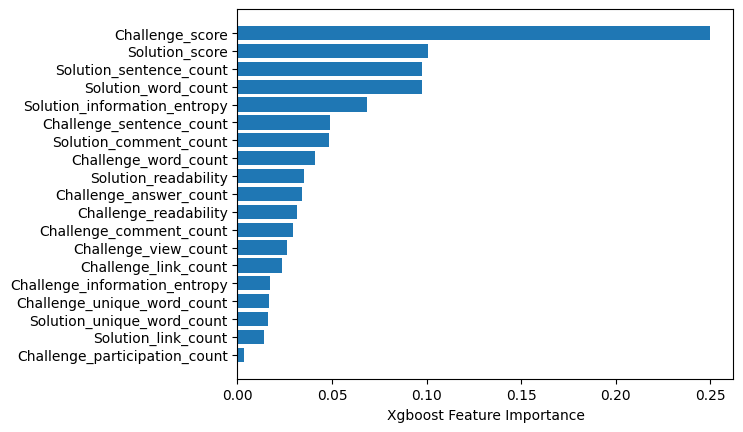

In [64]:
sorted_idx = regressor.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], regressor.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")


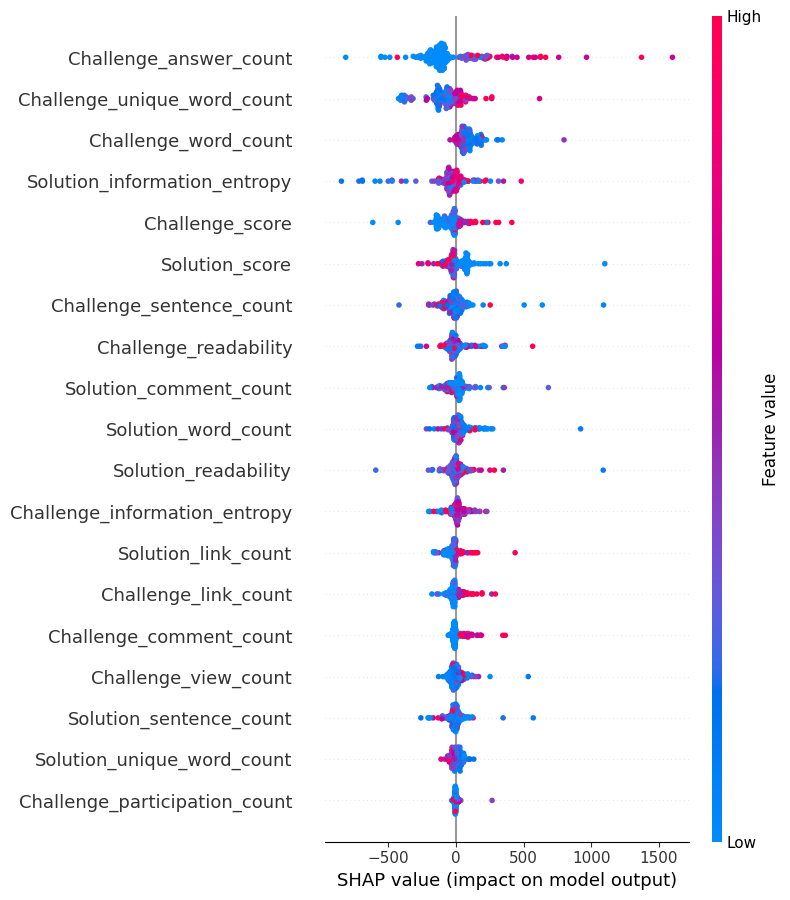

In [65]:
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


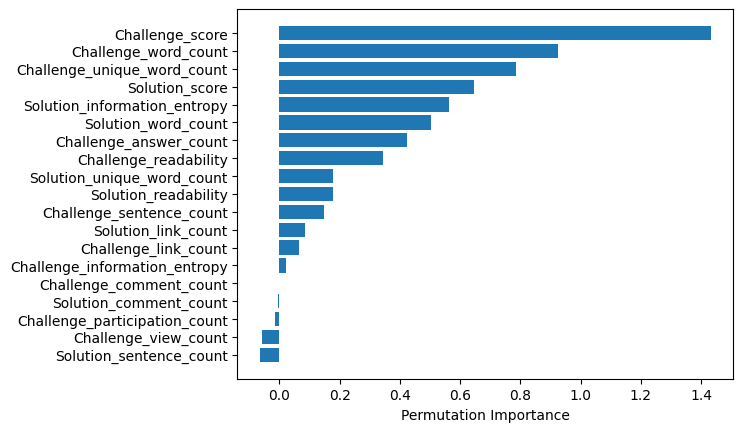

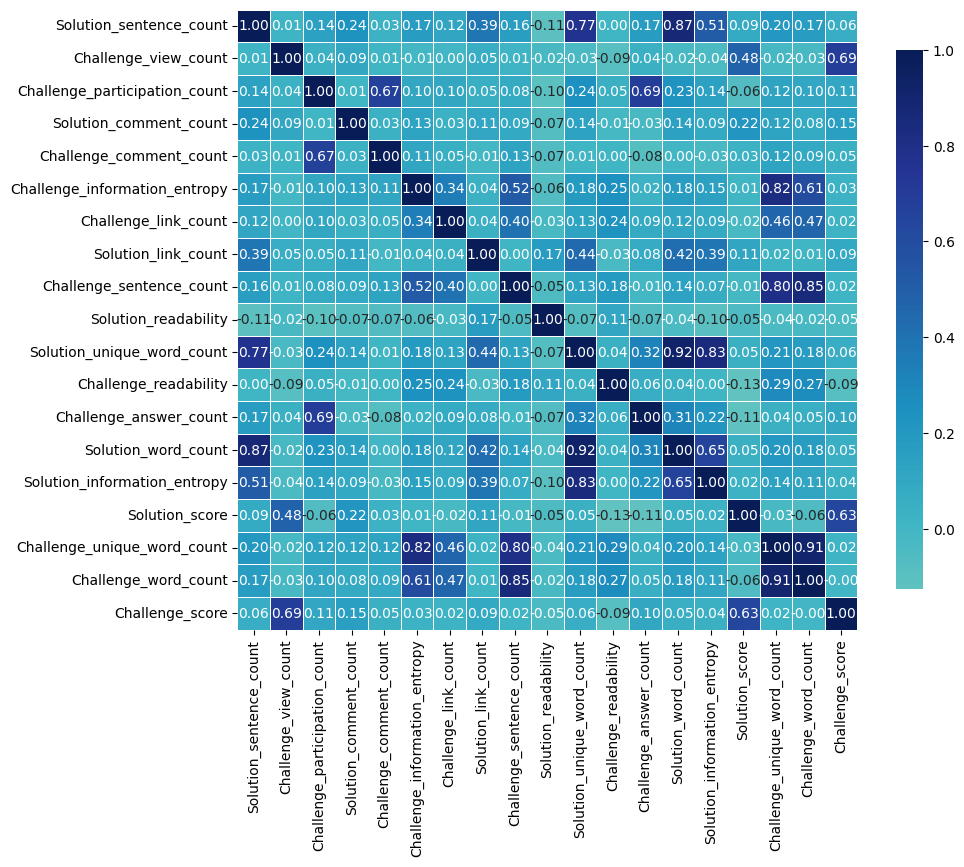

In [66]:
perm_importance = permutation_importance(regressor, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
    
correlation_heatmap(X_train[X_train.columns[sorted_idx]])


In [5]:
def smooth(x, y, xgrid, lowess_kw=None):
    samples = np.random.choice(len(x), 50, replace=True)
    y_s = y[samples]
    x_s = x[samples]
    y_sm = sm_lowess(y_s, x_s, **lowess_kw)
    # regularly sample it onto the grid
    y_grid = scipy.interpolate.interp1d(
        x_s, y_sm, fill_value='extrapolate')(xgrid)
    return y_grid


def lowess_with_confidence_bounds(x, y, conf_interval, K, lowess_kw):
    """
    Perform Lowess regression and determine a confidence interval by bootstrap resampling
    """
    xgrid = np.linspace(x.min(), x.max())
    
    smooths = np.stack([smooth(x, y, xgrid, lowess_kw) for _ in range(K)]).T

    mean = np.nanmean(smooths, axis=1)

    clower = np.nanpercentile(smooths, (1-conf_interval)*50, axis=1)
    cupper = np.nanpercentile(smooths, (1+conf_interval)*50, axis=1)

    return xgrid, mean, clower, cupper

In [12]:
# plot challenge topic count over time

df_challenge = pd.read_json(os.path.join(path_general, 'filtered.json'))

fig_challenge_topic_count = go.Figure()
fig_challenge_view_count = go.Figure()

for name, group in df_challenge.groupby('Challenge_topic_macro'):
    group_M = group.groupby(pd.Grouper(key='Challenge_creation_time', freq='M')).agg(Count=('Challenge_topic_macro', 'count')).reset_index()
    x = pd.to_datetime(group_M['Challenge_creation_time']).values
    y = group_M['Count'].values
    x_lowess = np.array([i.astype('datetime64[D]').astype(int) for i in x])
    xgrid, mean, clower, cupper = lowess_with_confidence_bounds(x_lowess, y, conf_interval=1-alpha, K=100, lowess_kw={"frac": 0.5, "it": 5, "return_sorted": False})
    xgrid = pd.to_datetime(xgrid, unit='D')    
    fig = go.Figure()    
    fig.add_trace(go.Scatter(x=x, y=y, name='Observations', mode='markers', marker=dict(size=3, color="black")))
    fig.add_trace(go.Scatter(x=xgrid, y=mean, name='LOWESS', mode="lines", line=dict(color="tomato")))
    fig.add_trace(go.Scatter(x=xgrid, y=cupper, fill=None, line_color='rgba(255,255,255,0)', showlegend=False))
    fig.add_trace(go.Scatter(x=xgrid, y=clower, fill='tonexty', fillcolor='rgba(0,100,80,0.2)', line_color='rgba(255,255,255,0)', showlegend=False))
    fig.update_layout(width=1000, height=500, margin=dict(l=0, r=0, t=0, b=0))
    fig.write_image(os.path.join(path_challenge_evolution, f'Challenge_topic_count_{name}.png'))
    
    group_Y = group.groupby(pd.Grouper(key='Challenge_creation_time', freq='Y')).agg(Count=('Challenge_topic_macro', 'count')).reset_index()
    x = pd.to_datetime(group_Y['Challenge_creation_time']).values
    y = group_Y['Count'].values
    diff = np.diff(y)
    diff = np.insert(diff, 0, 0)
    fig_challenge_topic_count.add_trace(go.Scatter(x=x, y=diff, mode='lines', name=name))
    
    # plot challenge topic view over time
    group_M = group.groupby(pd.Grouper(key='Challenge_creation_time', freq='Y')).agg(Count=('Challenge_view_count', 'count')).reset_index()
    x = pd.to_datetime(group_M['Challenge_creation_time']).values
    y = group_M['Count'].values
    x_lowess = np.array([i.astype('datetime64[D]').astype(int) for i in x])
    xgrid, mean, clower, cupper = lowess_with_confidence_bounds(x_lowess, y, conf_interval=1-alpha, K=100, lowess_kw={"frac": 0.5, "it": 5, "return_sorted": False})
    xgrid = pd.to_datetime(xgrid, unit='D')    
    fig = go.Figure()    
    fig.add_trace(go.Scatter(x=x, y=y, name='Observations', mode='markers', marker=dict(size=3, color="black")))
    fig.add_trace(go.Scatter(x=xgrid, y=mean, name='LOWESS', mode="lines", line=dict(color="tomato")))
    fig.add_trace(go.Scatter(x=xgrid, y=cupper, fill=None, line_color='rgba(255,255,255,0)', showlegend=False))
    fig.add_trace(go.Scatter(x=xgrid, y=clower, fill='tonexty', fillcolor='rgba(0,100,80,0.2)', line_color='rgba(255,255,255,0)', showlegend=False))
    fig.update_layout(width=1000, height=500, margin=dict(l=0, r=0, t=0, b=0))
    fig.write_image(os.path.join(path_challenge_evolution, f'Challenge_view_count_{name}.png'))
    
    group_Y = group.groupby(pd.Grouper(key='Challenge_creation_time', freq='Y')).agg(Count=('Challenge_view_count', 'count')).reset_index()
    x = pd.to_datetime(group_Y['Challenge_creation_time']).values
    y = group_Y['Count'].values
    diff = np.diff(y)
    diff = np.insert(diff, 0, 0)
    fig_challenge_view_count.add_trace(go.Scatter(x=x, y=diff, mode='lines', name=name))
    
fig_challenge_topic_count.update_layout(
    width=2000,
    height=1000,
    margin=dict(l=0, r=0, t=0, b=0))
fig_challenge_view_count.update_layout(
    width=2000,
    height=1000,
    margin=dict(l=0, r=0, t=0, b=0))

fig_challenge_topic_count.write_image(os.path.join(path_challenge_evolution, f'Challenge_topic_count_increase_rate.png'))
fig_challenge_view_count.write_image(os.path.join(path_challenge_evolution, f'Challenge_view_count_increase_rate.png'))